In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-05-03 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54,99,112,131,135,150,166,179,188,188,207,220,228,252,260,310,331
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277,283,302,314,327,345,356,385,394,403,410,422,431,455,470,488,519
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783,846,894,1047,1099,1152,1204,1355,1408,1479,1508,1558,1651,1702,1779,1821,1872
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169,191,205,235,248,282,309,333,344,344,344,385,398,423,468,468,472
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,7,7,11,11


In [7]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-28,83940,78422,4637,22,48,0
2020-04-29,83944,78474,4637,4,52,0
2020-04-30,83956,78523,4637,12,49,0
2020-05-01,83959,78573,4637,3,50,0
2020-05-02,83959,78586,4637,0,13,0


* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [8]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-28,160085,130531,6054,896,0,212
2020-04-29,160963,130531,6256,878,0,202
2020-04-30,161805,130531,6603,842,0,347
2020-05-01,162249,130531,6736,444,0,133
2020-05-02,162473,130531,6812,224,0,76


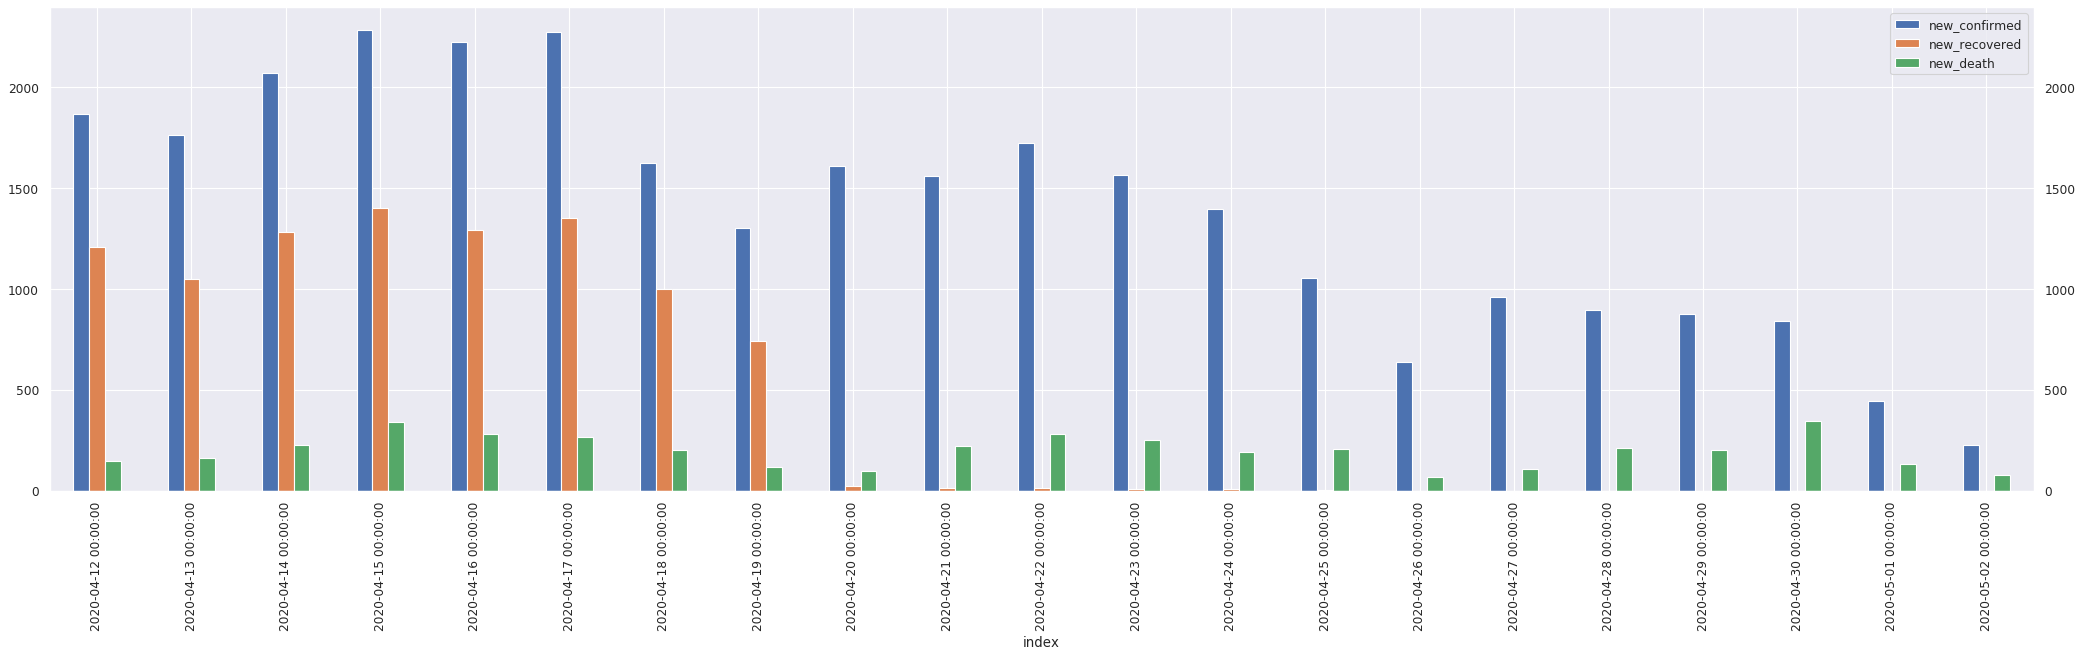

In [9]:
cbr_germany.plot_daily_stats()

[COVID-19-Pandemie#Deutschland](https://de.wikipedia.org/wiki/COVID-19-Pandemie#Deutschland):

> Am 22. März 2020 einigten sich Bund und Länder auf ein „umfassendes Kontaktverbot“, statt weitergehende Ausgangssperren zu beschließen.


> Roughly 2020-04-21 the taken actions show clear effect; roughly 4.5 weeks later.

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate  | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-21 |  92845 | 0.057 | - |
| 2020-04-03 | 2020-04-23 |  99774 | 0.054 | - |
| 2020-04-04 | 2020-04-25 | 107193 | 0.051 | - |
| 2020-04-05 | 2020-04-27 | 114511 | 0.049 | - |
| 2020-04-06 | 2020-04-29 | 119618 | 0.045 | - |
| 2020-04-07 | 2020-04-29 | 121354 | 0.039 | - |
| 2020-04-08 | 2020-04-30 | 123011 | 0.035 | - |
| 2020-04-09 | 2020-04-30 | 125833 | 0.031 | - |
| 2020-04-10 | - | - | 0.049 | 4820 |
| 2020-04-11 | - | - | 0.042 | 4739 |
| 2020-04-12 | - | - | 0.040 | 4570 |
| 2020-04-13 | - | - | 0.036 | 4300 |
| 2020-04-14 | - | - | 0.033 | 3927 |
| 2020-04-15 | - | - | 0.029 | 3451 |
| 2020-04-16 | - | - | 0.026 | 3086 |
| 2020-04-17 | - | - | 0.024 | 2845 |
| 2020-04-19 | - | - | 0.021 | 2666 |
| 2020-04-20 | - | - | 0.020 | 2554 |
| 2020-04-21 | - | - | 0.018 | 2356 |
| 2020-04-24 | - | - | 0.015 | 2043 |
| 2020-04-25 | 2020-05-24 | 166654 | 0.011 | - |
| 2020-04-26 | 2020-05-26 | 167739 | 0.010 | - |
| 2020-04-27 | 2020-05-26 | 168771 | 0.009 | - |
| 2020-04-28 | - | - | 0.013 | 1538 |
| 2020-04-29 | 2020-05-25 | 169856 | 0.008 | - |
| 2020-04-30 | 2020-05-26 | 170081 | 0.007 | - |
| 2020-05-01 | 2020-06-06 | 176154 | 0.007 | - |
| 2020-05-02 | 2020-06-06 | 176278 | 0.006 | - |
| 2020-05-03 | 2020-06-06 | 176466 | 0.006 | - |

In [10]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


In [11]:
# cbr_germany.fit_df0.loc[pd.to_datetime('2020-05-24')]

sigmoid+asymmetric: seor: 501.9368274166469, max asymptotic: 176466.28968833436; growth-rate: 0.006, date:2020-06-06 00:00:00, projected value: 93.25860021336409


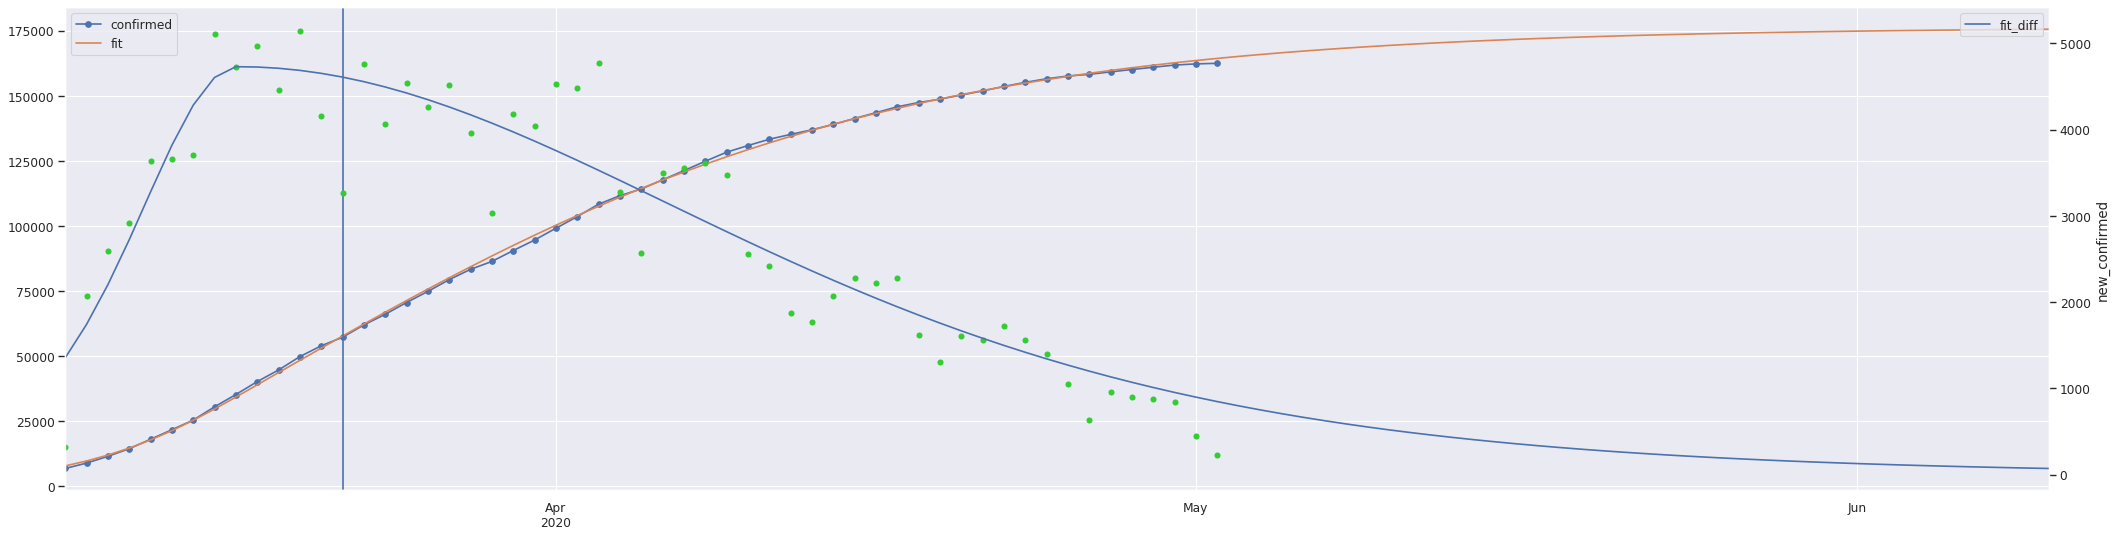

In [12]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [13]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4730.177313


In [14]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-30,0.614,0.487,0.301,0.39,0.497


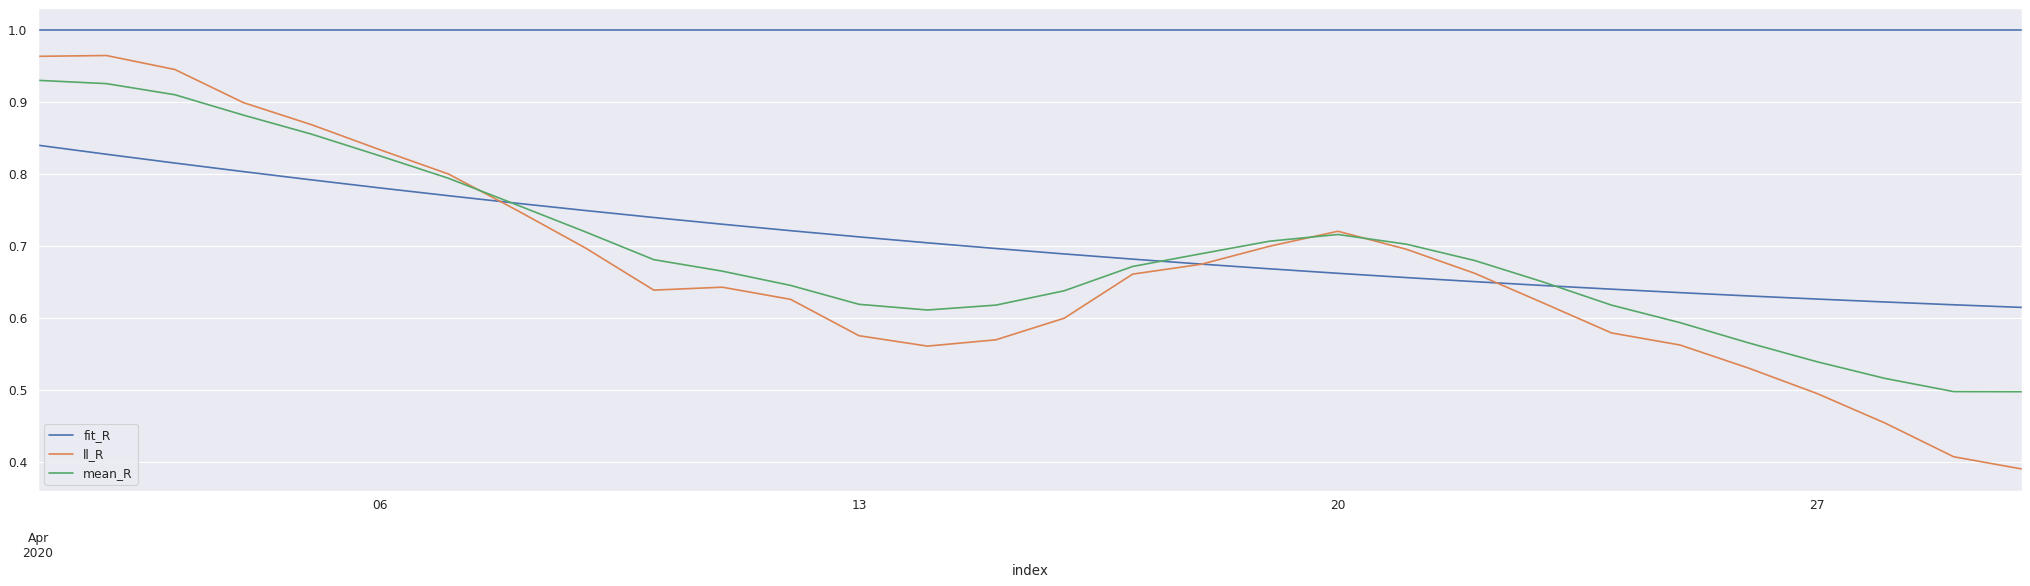

In [15]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [16]:
df = covid19.get_austria_df()
cbr_austria = covid19.CasesByRegion('Austria', df=df)
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-28,15286,12580,543,47,218,7
2020-04-29,15352,12779,554,66,199,11
2020-04-30,15424,12907,557,72,128,3
2020-05-01,15470,13092,561,46,185,4
2020-05-02,15508,13180,567,38,88,6


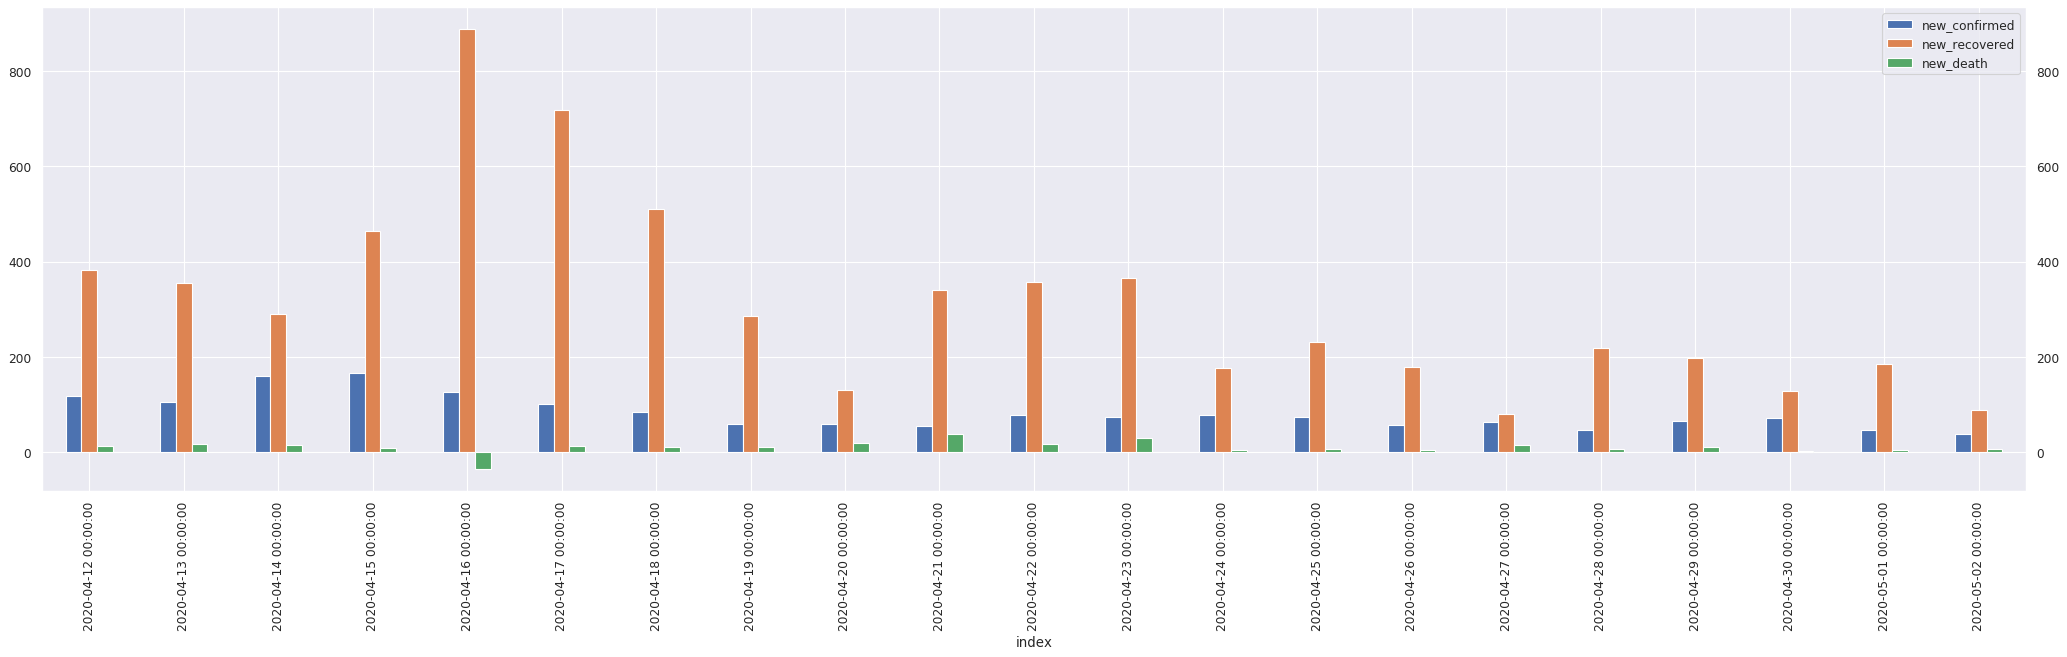

In [17]:
cbr_austria.plot_daily_stats()

[COVID-19-Pandemie#%C3%96sterreich](https://de.wikipedia.org/wiki/COVID-19-Pandemie#%C3%96sterreich)

> Nachdem Mitte März zuerst einzelne Gemeinden unter Quarantäne gestellt wurden, verlautbarte Bundeskanzler Sebastian Kurz am 15. März eine landesweite Ausgangsbeschränkung, verbunden mit einer Einschränkung der Versammlungsfreiheit auf bis zu fünf Personen.

`2020-03-15`

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-12 | 13859 | 0.042 | - |
| 2020-04-03 | 2020-04-12 | 13864 | 0.036 | - |
| 2020-04-04 | 2020-04-12 | 14082 | 0.030 | - |
| 2020-04-05 | 2020-04-12 | 13978 | 0.025 | - |
| 2020-04-06 | 2020-04-11 | 13947 | 0.020 | - |
| 2020-04-07 | 2020-04-12 | 14033 | 0.017 | - |
| 2020-04-08 | 2020-04-12 | 14121 | 0.014 | - |
| 2020-04-09 | 2020-04-12 | 14229 | 0.012 | - |
| 2020-04-10 | 2020-04-12 | 14350 | 0.010 | - |
| 2020-04-11 | 2020-04-13 | 14488 | 0.009 | - |
| 2020-04-12 | - | - | 0.012 | 106 |
| 2020-04-13 | - | - | 0.012 | 123 |
| 2020-04-14 | - | - | 0.011 | 126 |
| 2020-04-15 | - | - | 0.010 | 114 |
| 2020-04-15 | - | - | 0.009 | 107 |
| 2020-04-17 | - | - | 0.009 | 106 |
| 2020-04-19 | - | - | 0.007 |  95 |
| 2020-04-20 | - | - | 0.007 |  87 |
| 2020-04-21 | - | - | 0.006 |  83 |
| 2020-04-24 | - | - | 0.005 |  68 |
| 2020-04-26 | 2020-05-01 | 15208 | 0.002 |  - |
| 2020-04-27 | 2020-05-01 | 15096 | 0.002 |  - |
| 2020-04-28 | 2020-05-01 | 15129 | 0.002 |  - |
| 2020-04-29 | - | - | 0.005 |  84 |
| 2020-04-30 | - | - | 0.005 |  81 |
| 2020-05-01 | - | - | 0.005 |  77 |
| 2020-05-02 | - | - | 0.005 |  76 |
| 2020-05-02 | - | - | 0.004 |  75 |

In [18]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland
einwohner_österreich  =  8793370.0
prozent_österreich    = einwohner_österreich / einwohner_deutschland

austria_new_confirmed_threshold = (100.0 * prozent_österreich) // 1 + 1
austria_new_confirmed_threshold

11.0

In [19]:
cbr_austria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=austria_new_confirmed_threshold)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 86.18416779993204; growth-rate: 0.004, date:2020-06-10 00:00:00, projected value: 75.49486046258099


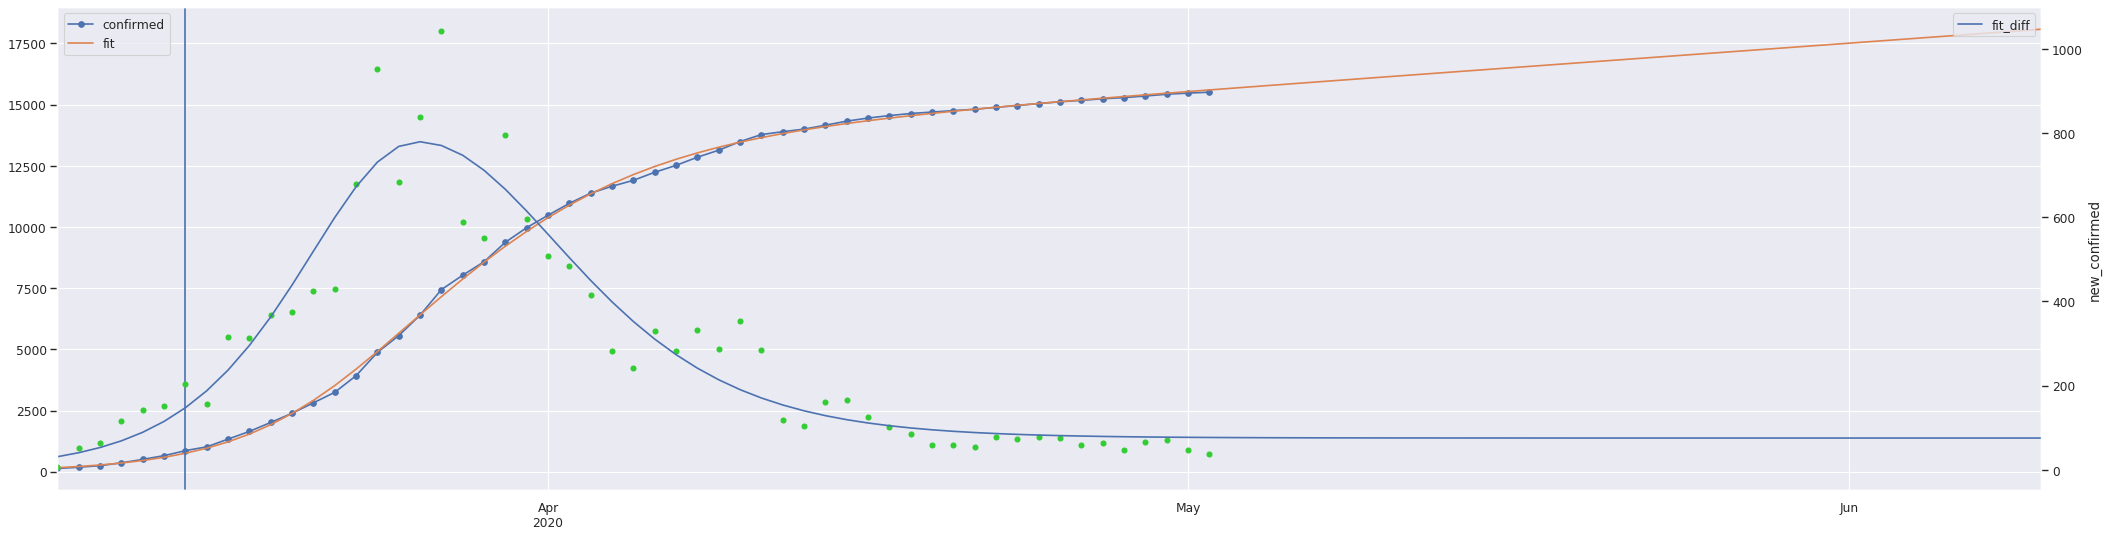

In [20]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 15))

In [21]:
cbr_austria.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,779.456559


In [22]:
cbr_austria.calculate_R_estimates()
cbr_austria.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-30,0.918,0.96,0.94,0.924,0.934


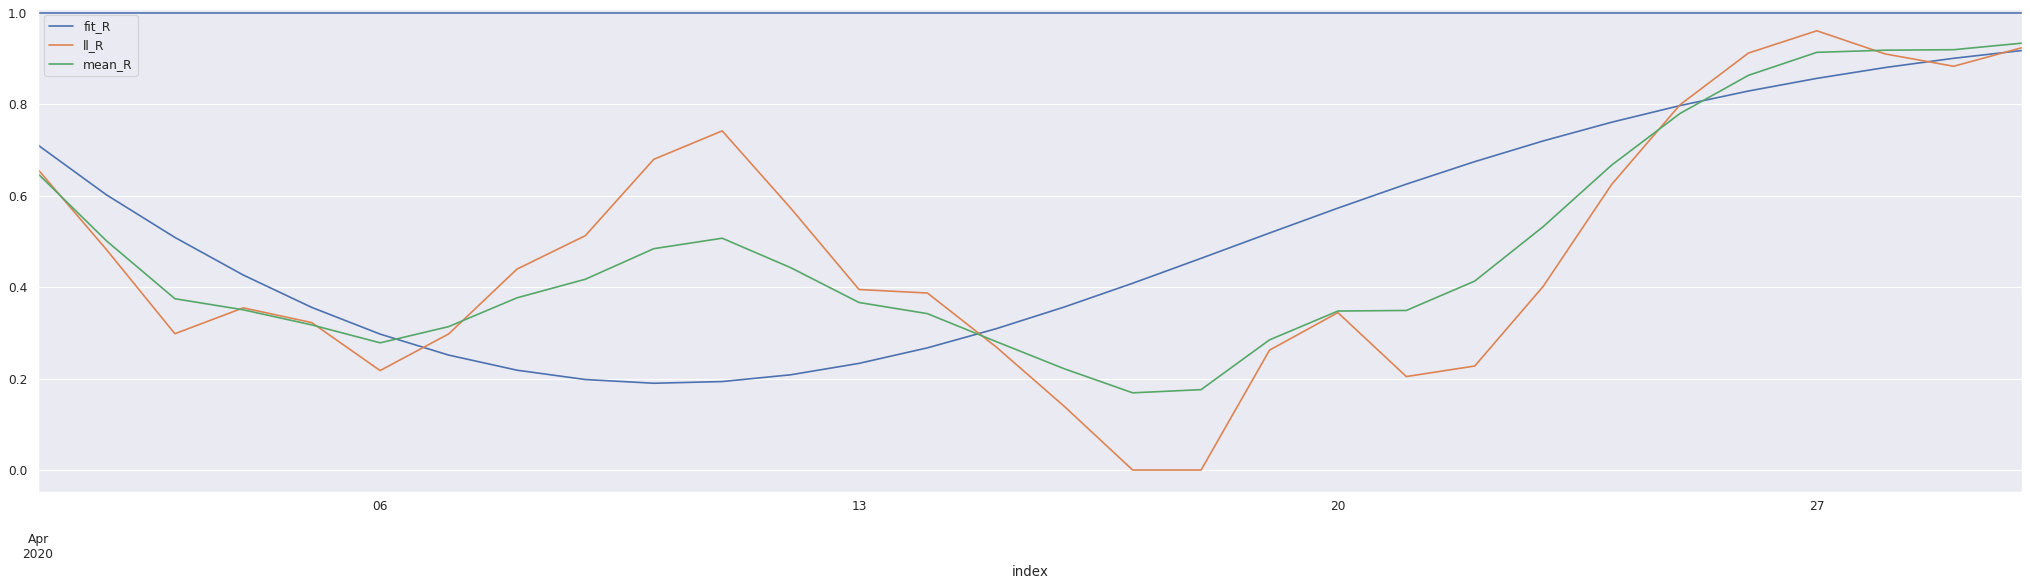

In [23]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

[COVID-19-Pandemie#Dänemark](https://de.wikipedia.org/wiki/COVID-19-Pandemie#D%C3%A4nemark)

> Dänemark hat besonders früh mit strikten Maßnahmen auf die Corona-Krise reagiert, unter anderem sind seit dem 14. März die Grenzen für Ausländer ohne triftigen Einreisegrund geschlossen.

`2020-03-14`

In [24]:
cbr_denmark = covid19.CasesByRegion('Denmark')
cbr_denmark.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-28,9049,6313,434,153,165,7
2020-04-29,9206,6558,443,157,245,9
2020-04-30,9356,6741,452,150,183,9
2020-05-01,9509,6924,460,153,183,8
2020-05-02,9605,7084,475,96,160,15


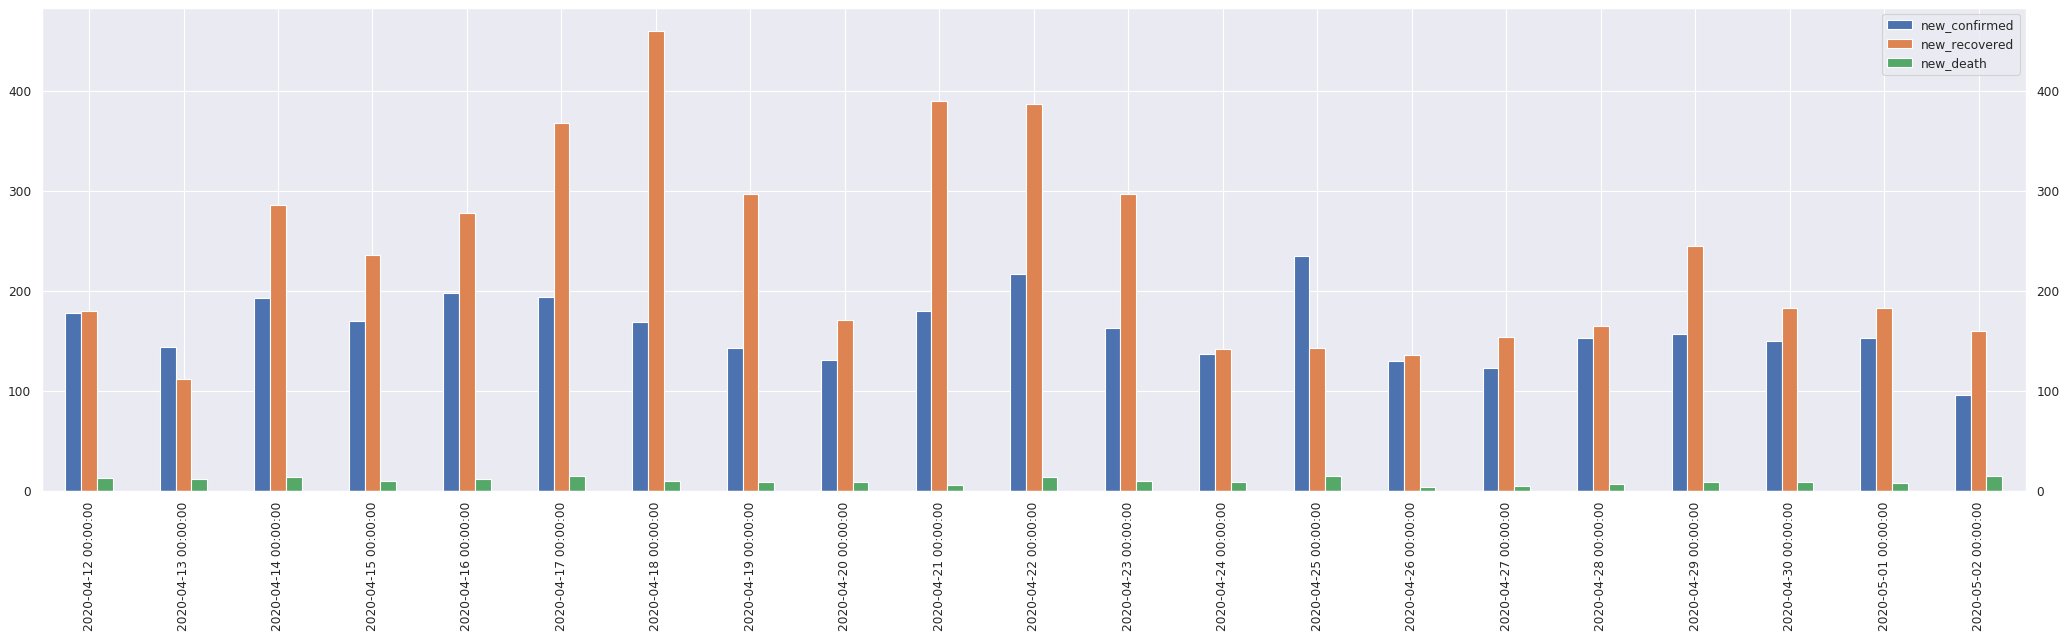

In [25]:
cbr_denmark.plot_daily_stats()

8.0


 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 1200./ None


sigmoid+asymmetric+linear: seor: 30.32353864426875; growth-rate: 0.02, date:2020-06-10 00:00:00, projected value: 166.91881602554355


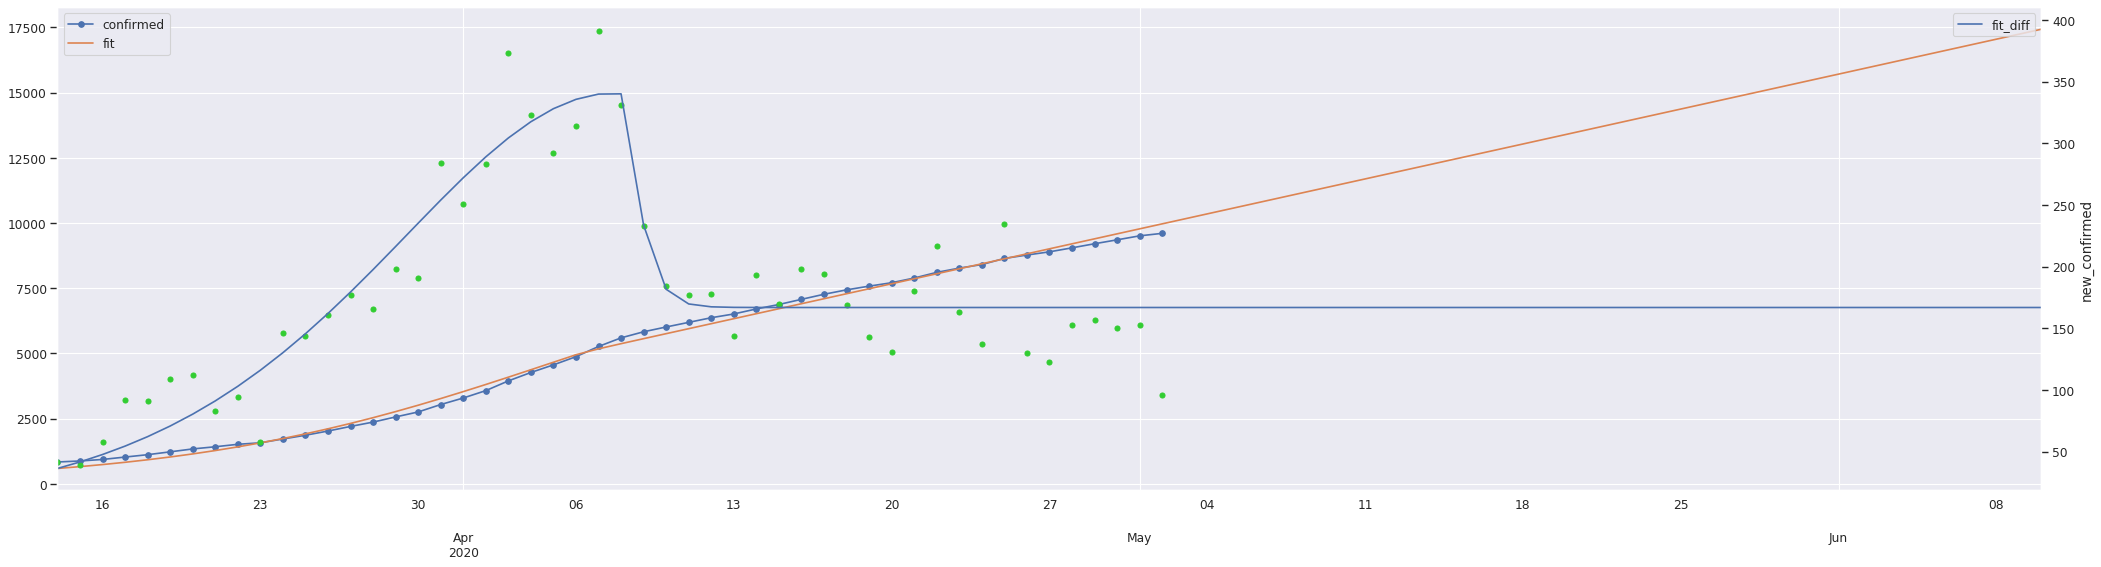

In [26]:
population_denmark  =  5822763.0
percent_denmark     = population_denmark / einwohner_deutschland

denmark_new_confirmed_threshold = (100.0 * percent_denmark) // 1 + 1
print(denmark_new_confirmed_threshold)

# first_date=pd.to_datetime('2020-03-09')
# first_date=pd.to_datetime('2020-03-14')
cbr_denmark.fit(first_date=pd.to_datetime('2020-03-14'), new_confirmed_threshold=denmark_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [27]:
cbr_denmark.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,340.140046


In [28]:
cbr_denmark.calculate_R_estimates()
cbr_denmark.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-30,1.0,0.869,0.83,0.868,0.912


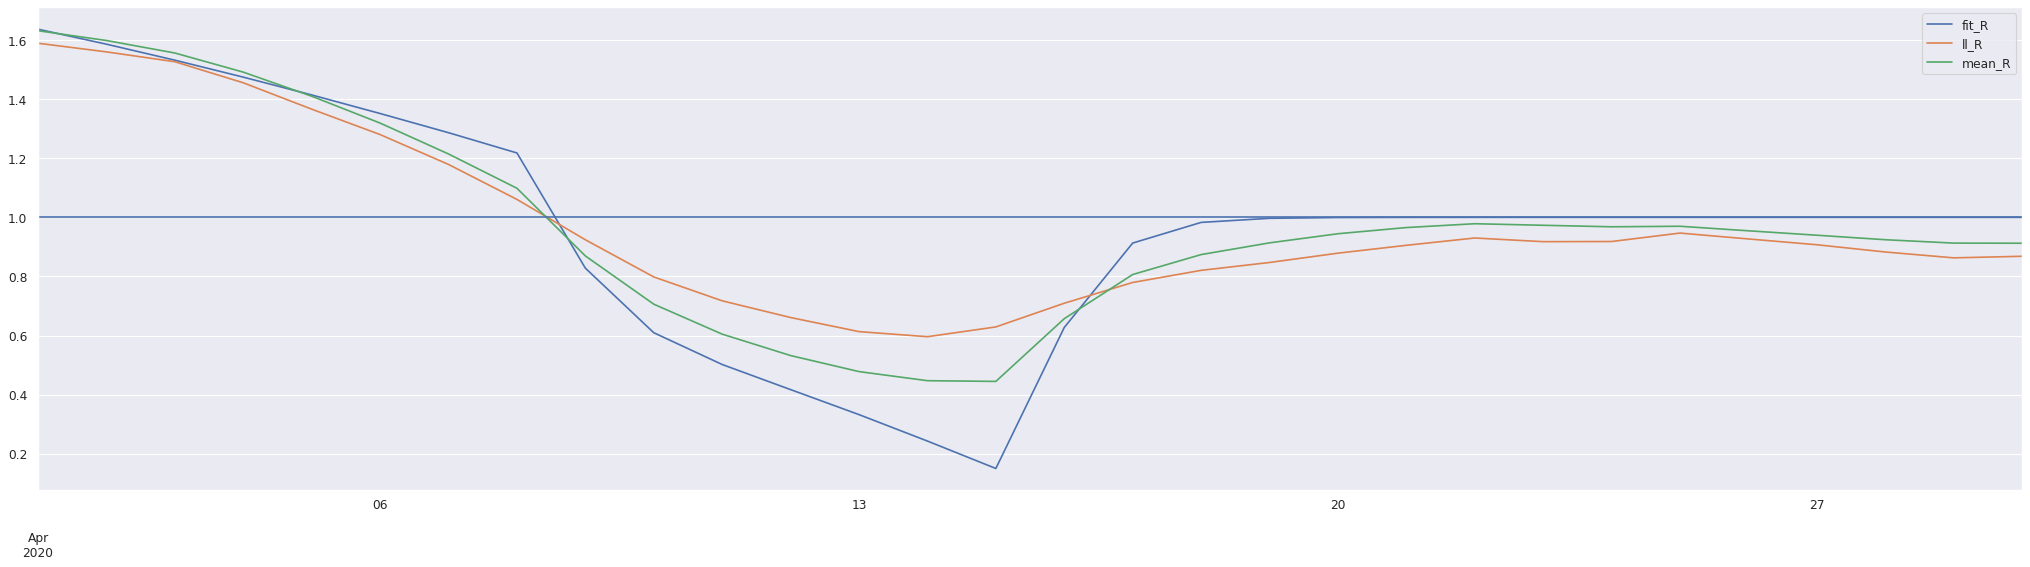

In [29]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_R(ax=ax) # , plot_start_date='2020-03-10'

There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [30]:
df = covid19.get_italy_df()
cbr_italy = covid19.CasesByRegion('Italy', df=df)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-28,201505,68941,27359,2091,2317,382
2020-04-29,203591,71252,27682,2086,2311,323
2020-04-30,205463,75945,27967,1872,4693,285
2020-05-01,207428,78249,28236,1965,2304,269
2020-05-02,209328,79914,28710,1900,1665,474


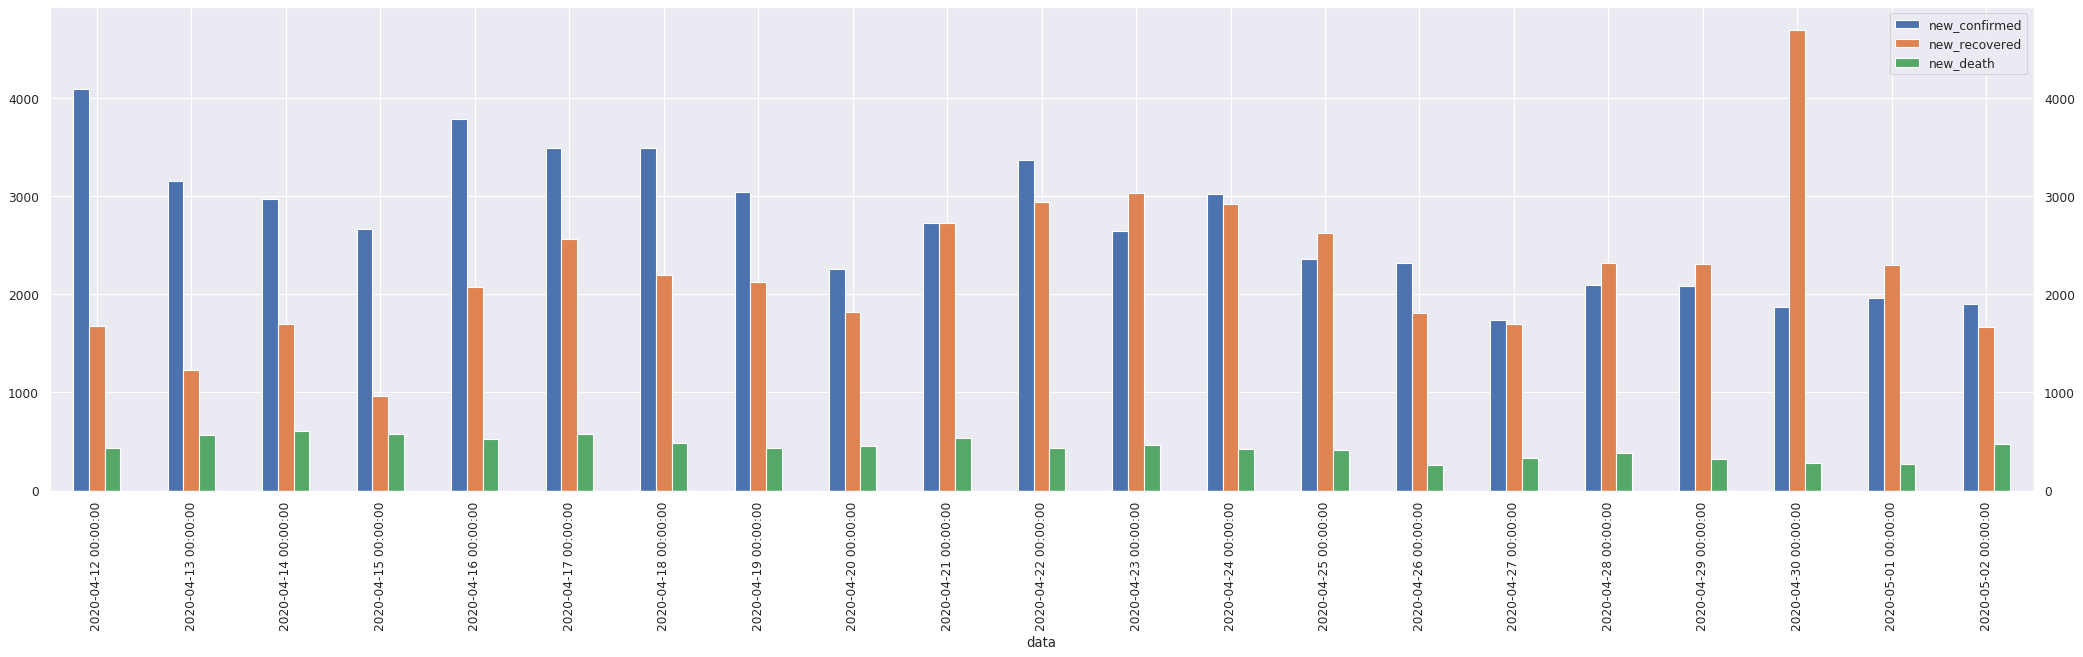

In [31]:
cbr_italy.plot_daily_stats()

In [32]:
cbr_italy.fit(first_date=pd.to_datetime('2020-02-21'))

sigmoid+asymmetric+linear: seor: 489.6146048267904; growth-rate: 0.012, date:2020-06-10 00:00:00, projected value: 1669.0623468396436


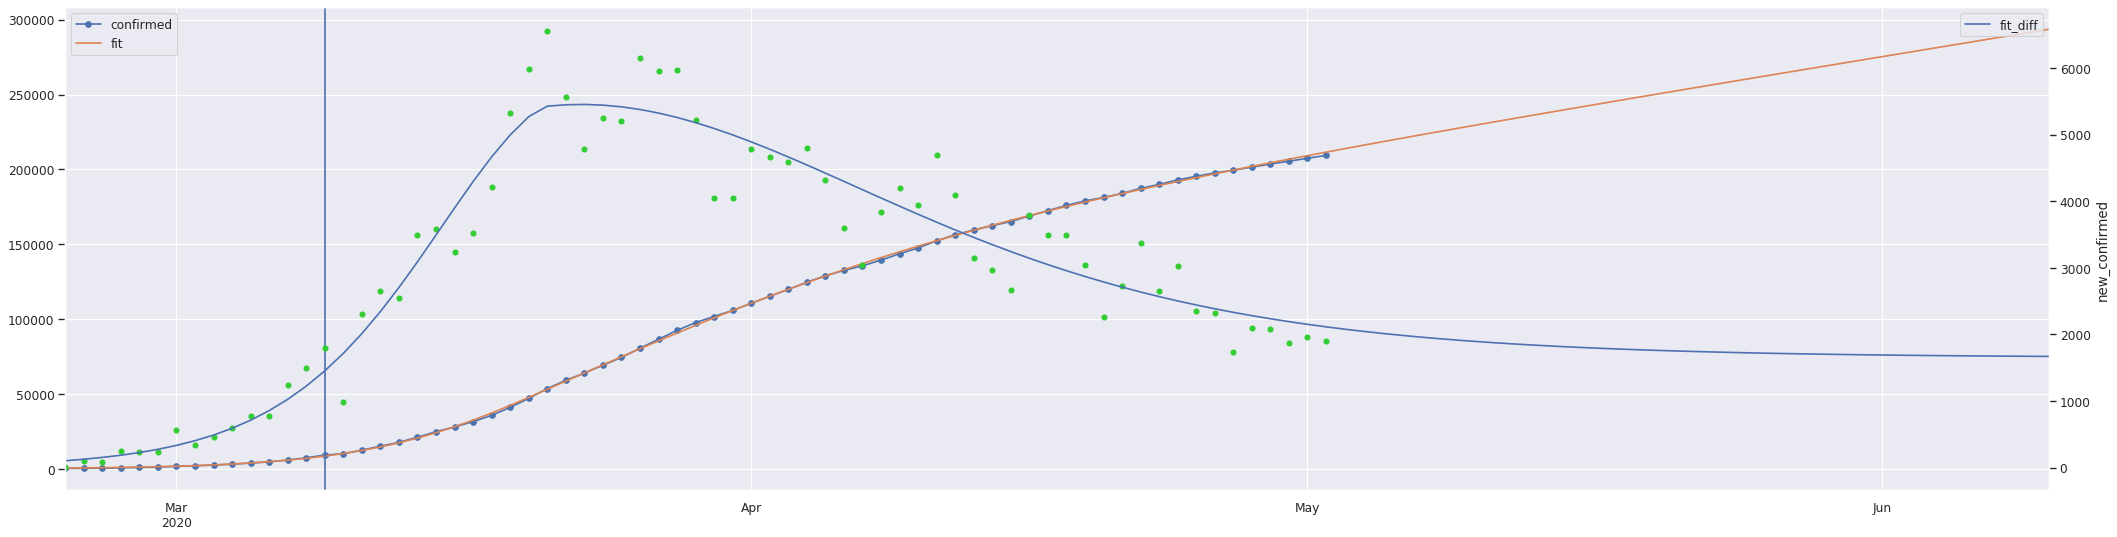

In [33]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 9))

In [34]:
cbr_italy.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5454.169449


In [35]:
cbr_italy.calculate_R_estimates()
cbr_italy.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
data,,,,,
2020-04-30,0.843,0.645,0.63,0.651,0.713


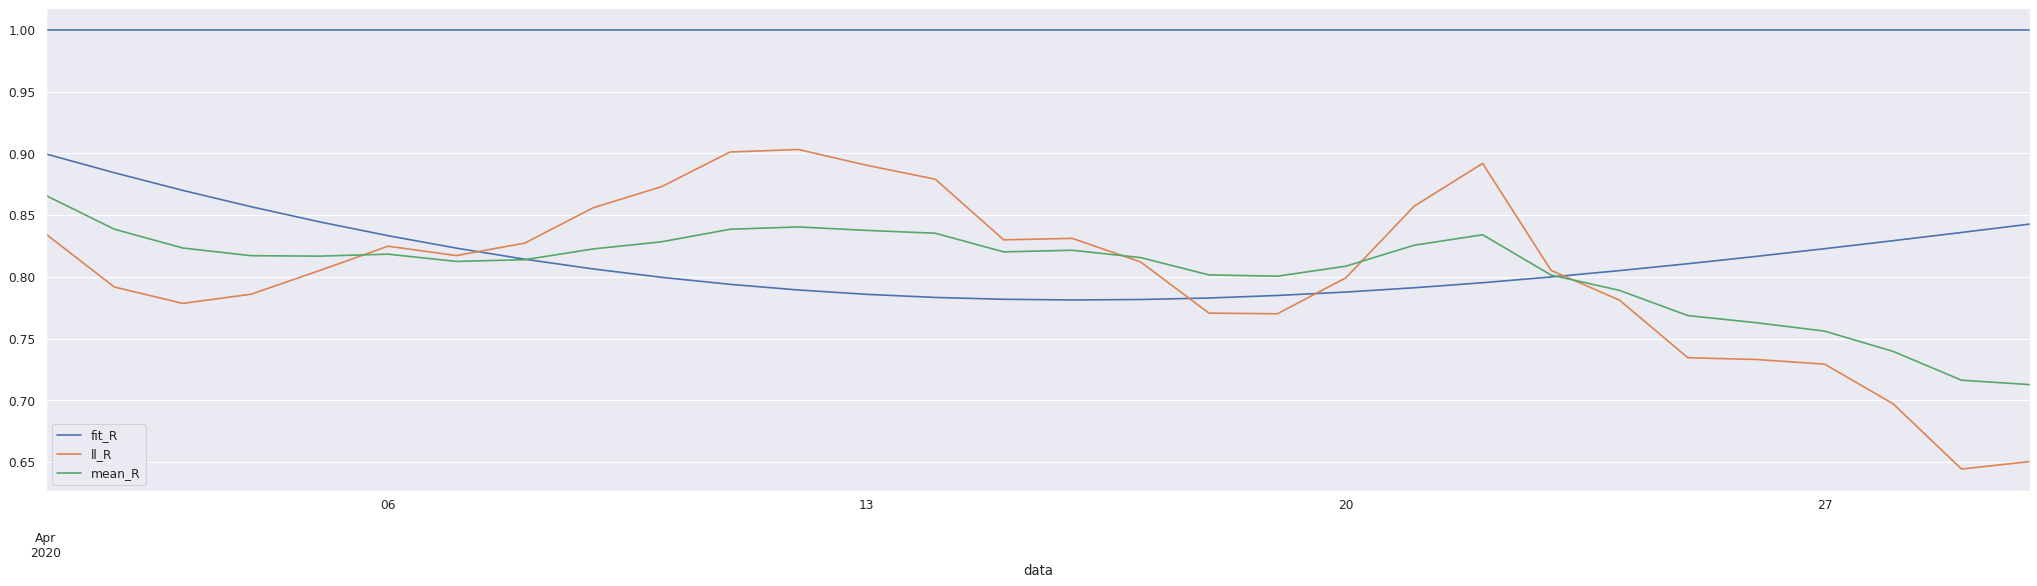

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)


* [mscbs.gob.es](https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm)
* https://covid19.isciii.es/
* [github/datadista](https://github.com/datadista/datasets/tree/master/COVID%2019)

In [37]:
df = covid19.get_spain_df()
cbr_spain = covid19.CasesByRegion('Spain', df=df)
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-28,233578,102548,23822,2845,1673,301
2020-04-29,236904,108947,24275,3326,6399,453
2020-04-30,240027,112050,24543,3123,3103,268
2020-05-01,243235,114678,24824,3208,2628,281
2020-05-02,245635,117248,25100,2400,2570,276


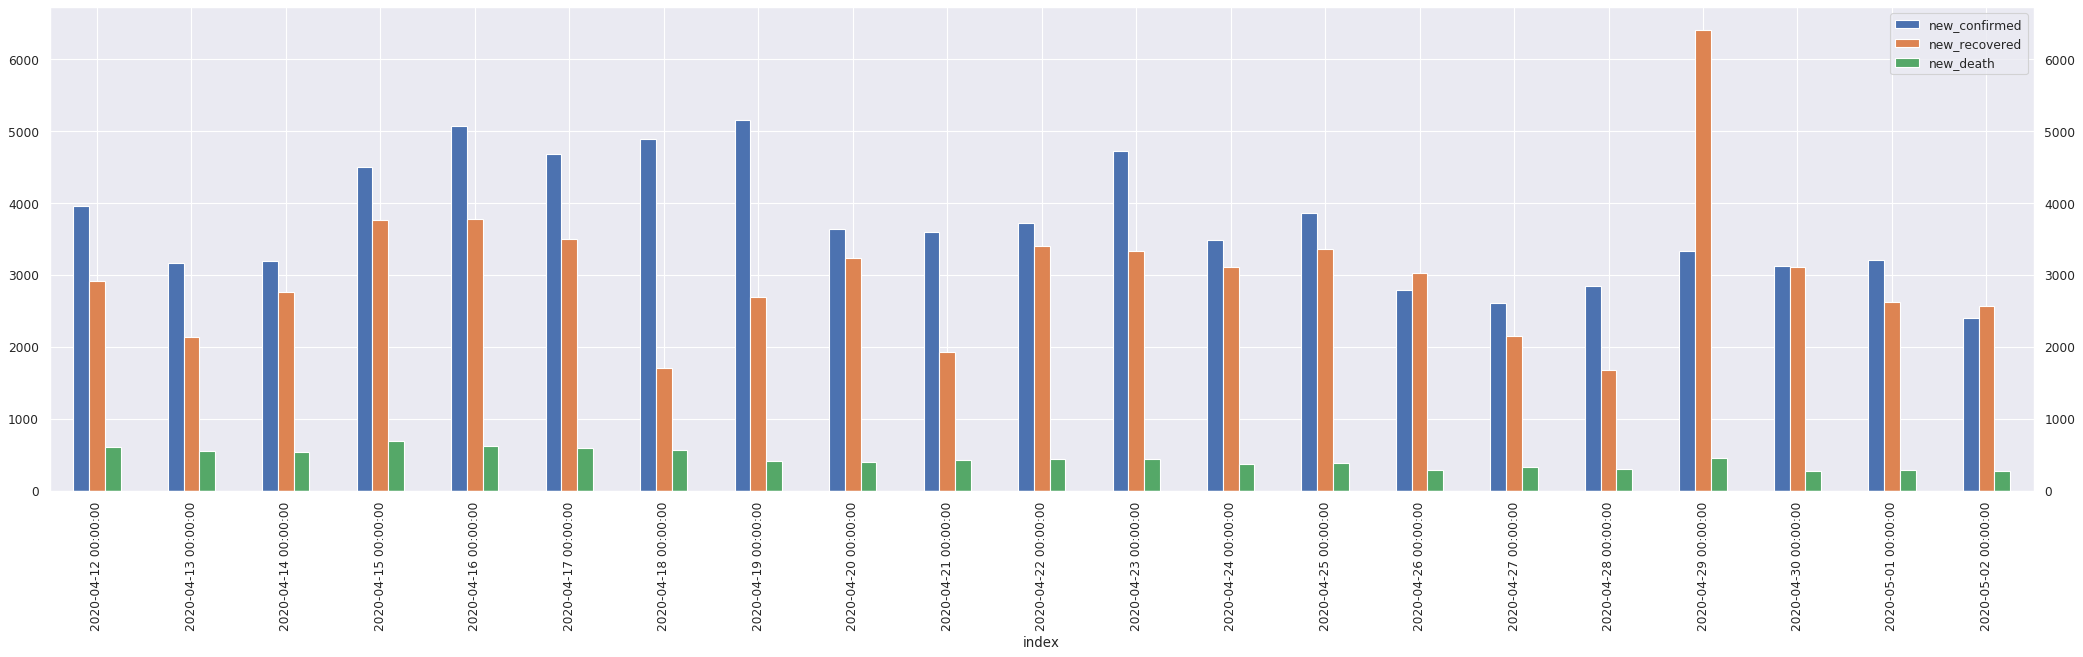

In [38]:
cbr_spain.plot_daily_stats()

In [39]:
cbr_spain.fit(first_date=pd.to_datetime('2020-03-04'))

sigmoid+asymmetric+linear: seor: 786.2554030722026; growth-rate: 0.016, date:2020-06-10 00:00:00, projected value: 3519.6194978505496


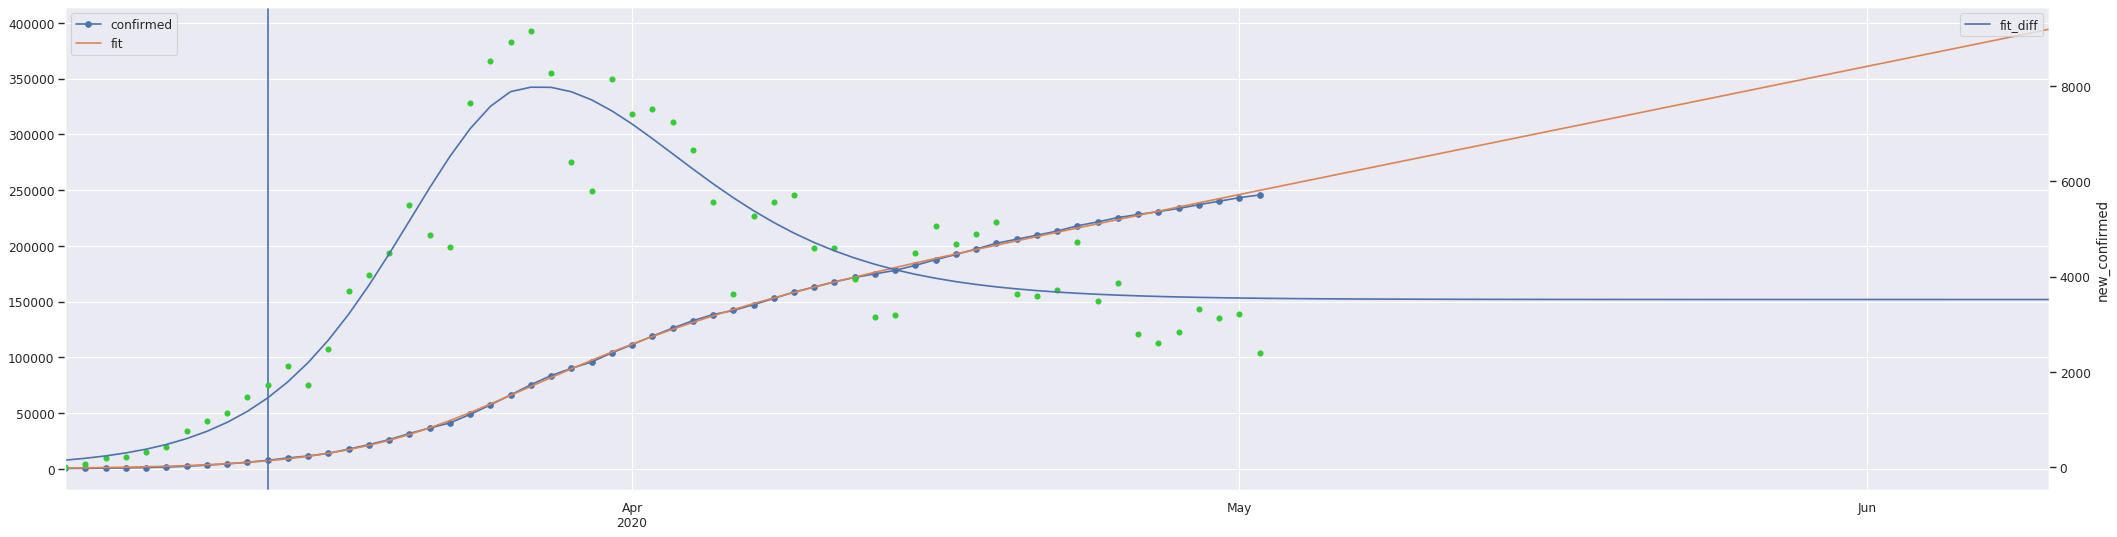

In [40]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [41]:
cbr_spain.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,7973.404143


In [42]:
cbr_spain.calculate_R_estimates()
cbr_spain.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-30,0.974,0.717,0.587,0.593,0.761


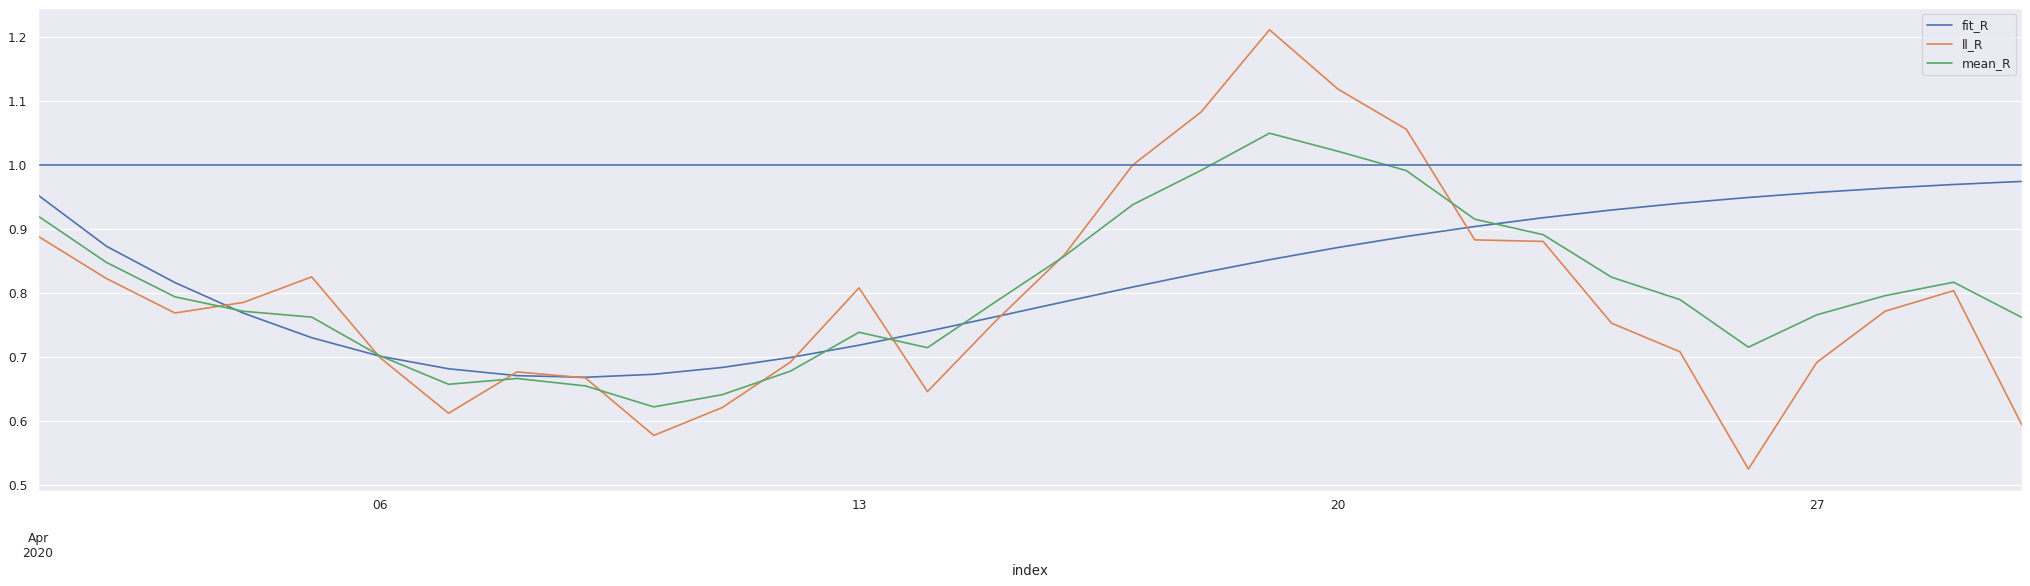

In [43]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)



* [opencovid19-fr / data](https://github.com/opencovid19-fr/data/blob/master/README.en.md)
    * [chiffres-cles.csv](https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv)
    * [dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/5e09dff7cb434fb194e22261689e2887)
    * [santepubliquefrance](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde)

In [44]:
df =covid19.get_france_df()
cbr_france = covid19.CasesByRegion('France', df=df)
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-04-28,129859,46886,23660,1520,1373,367
2020-04-29,128442,48228,24087,-1417,1342,427
2020-04-30,129581,49476,24376,1139,1248,289
2020-05-01,130185,50212,24594,604,736,218
2020-05-02,130979,50562,24760,794,350,166


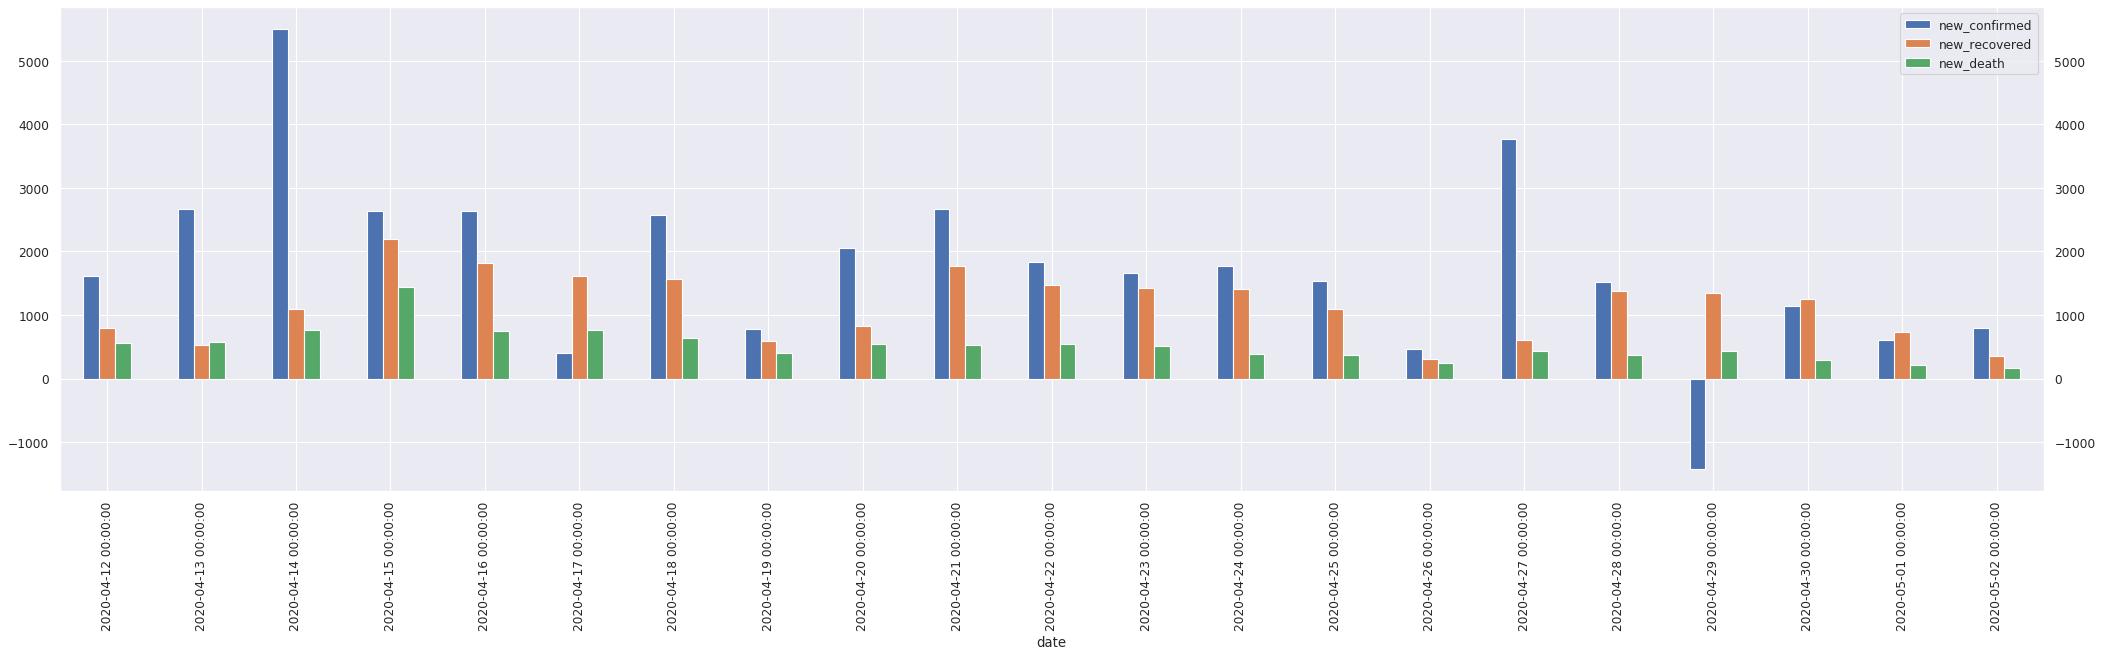

In [45]:
cbr_france.plot_daily_stats()

In [46]:
cbr_france.fit(first_date=pd.to_datetime('2020-03-04'))

sigmoid+asymmetric: seor: 1068.0826171817105, max asymptotic: 141130.77917023608; growth-rate: 0.008, date:2020-05-26 00:00:00, projected value: 84.20251498761458


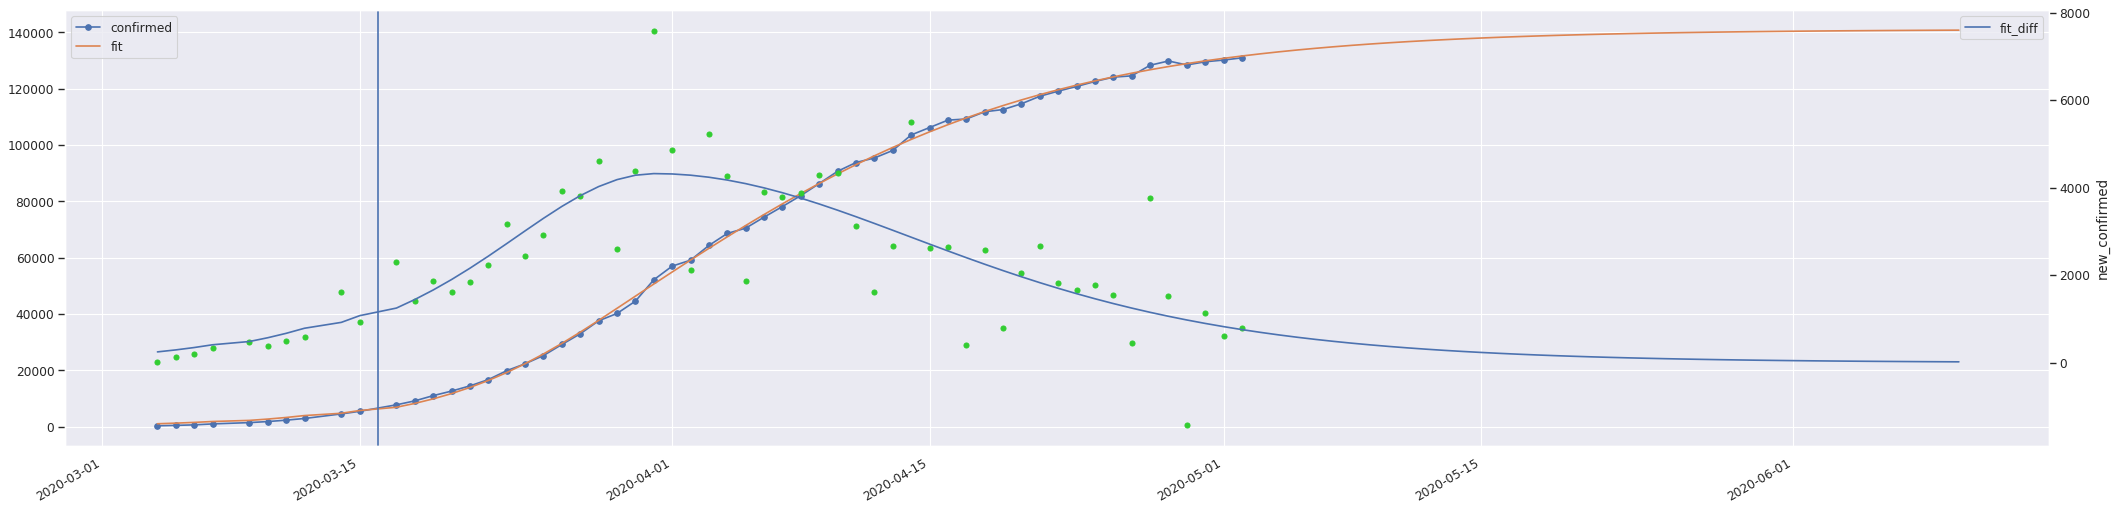

In [47]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 16))

In [48]:
cbr_france.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4323.298249


In [49]:
cbr_france.calculate_R_estimates()
cbr_france.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
date,,,,,
2020-04-30,0.461,0.5,0.188,0.54,0.5


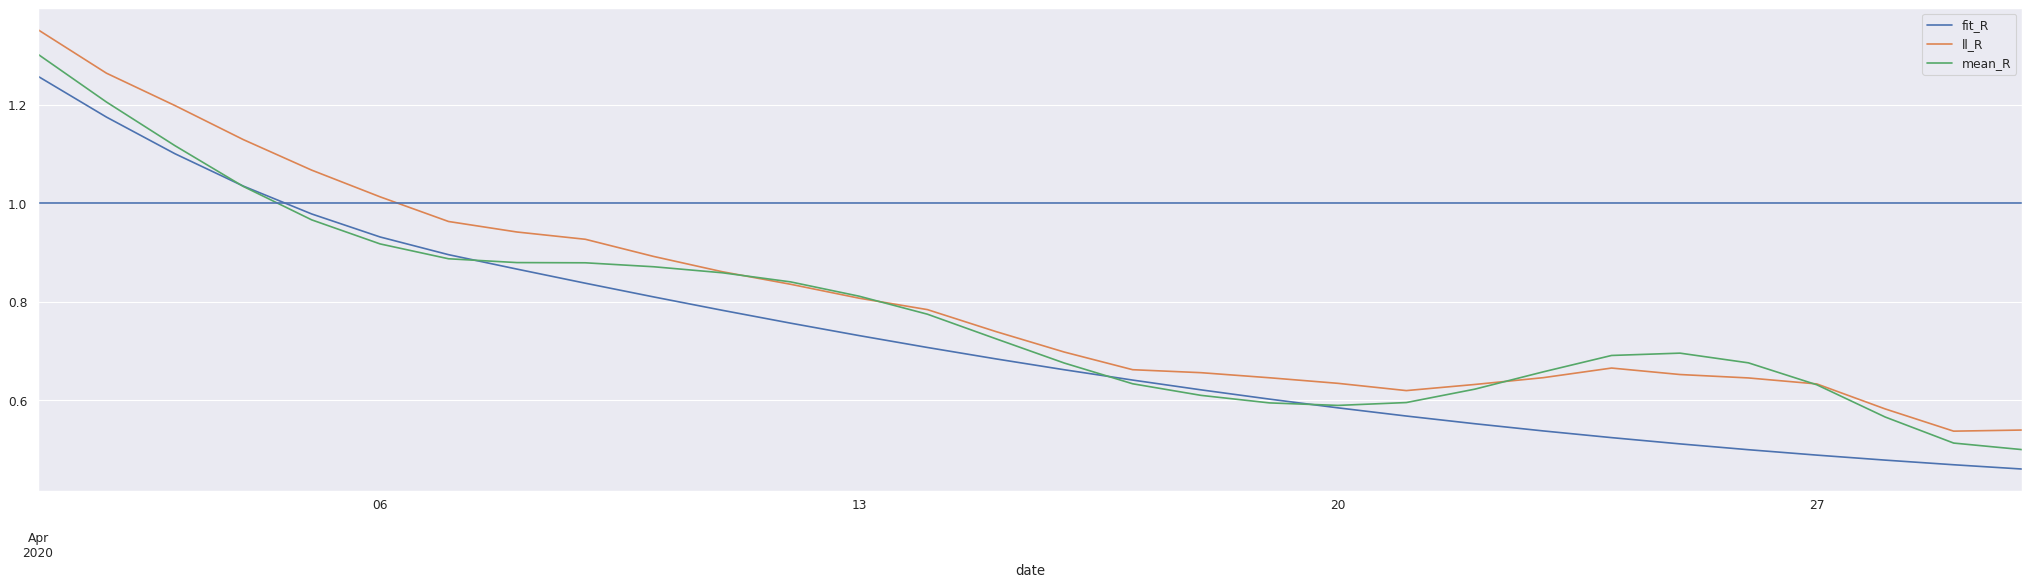

In [50]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [51]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-28,10761,8922,246,9,68,2
2020-04-29,10765,9059,247,4,137,1
2020-04-30,10774,9072,248,9,13,1
2020-05-01,10780,9123,250,6,51,2
2020-05-02,10793,9183,250,13,60,0


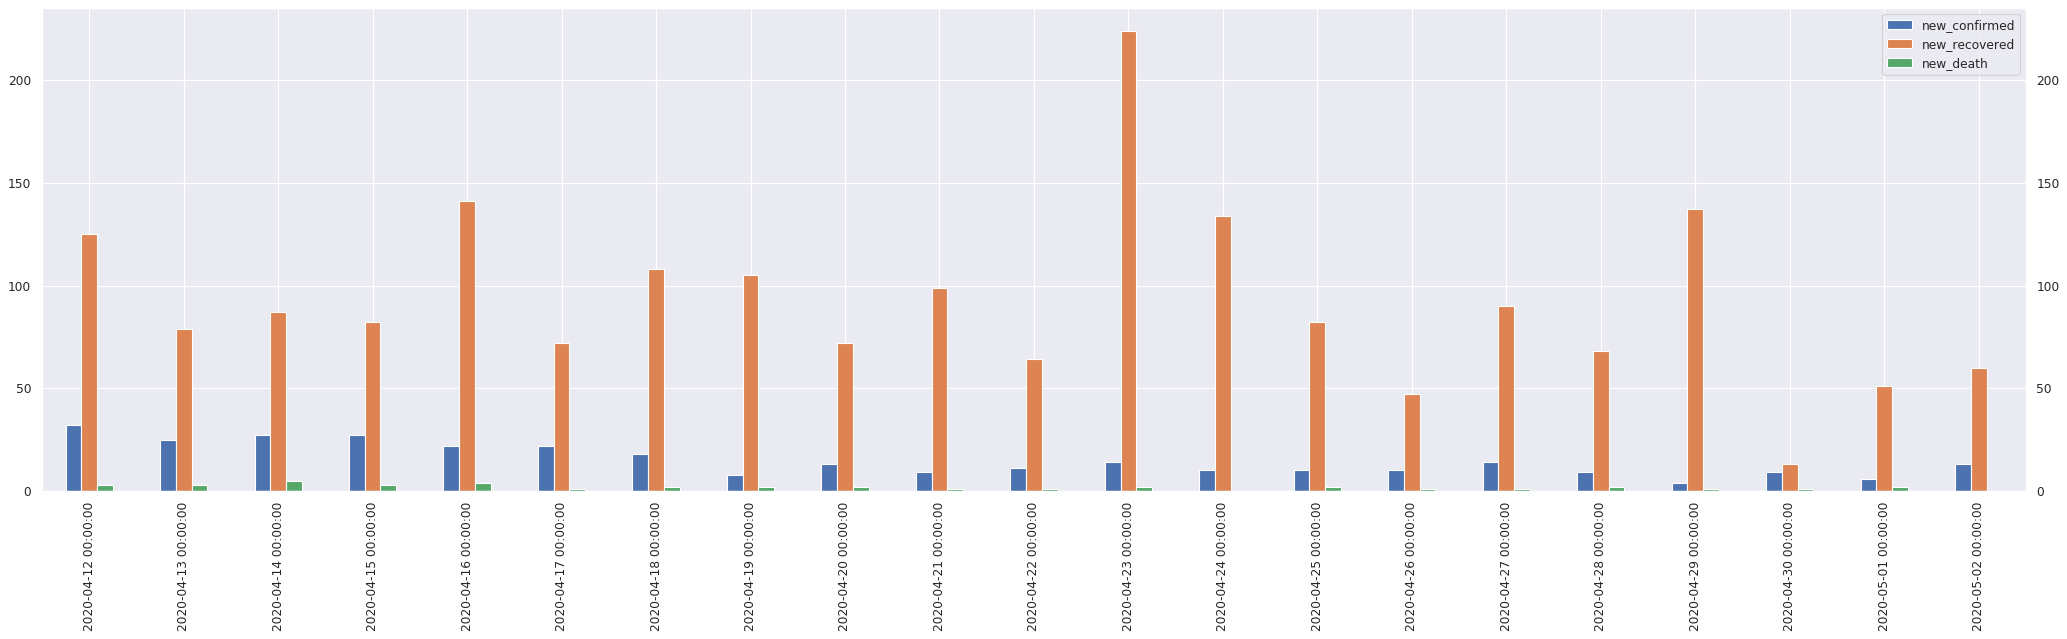

In [52]:
cbr_south_korea.plot_daily_stats()

In [53]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-28,162350,813,25369,4002,6,911
2020-04-29,166441,857,26166,4091,44,797
2020-04-30,172481,859,26842,6040,2,676
2020-05-01,178685,892,27583,6204,33,741
2020-05-02,183500,896,28205,4815,4,622


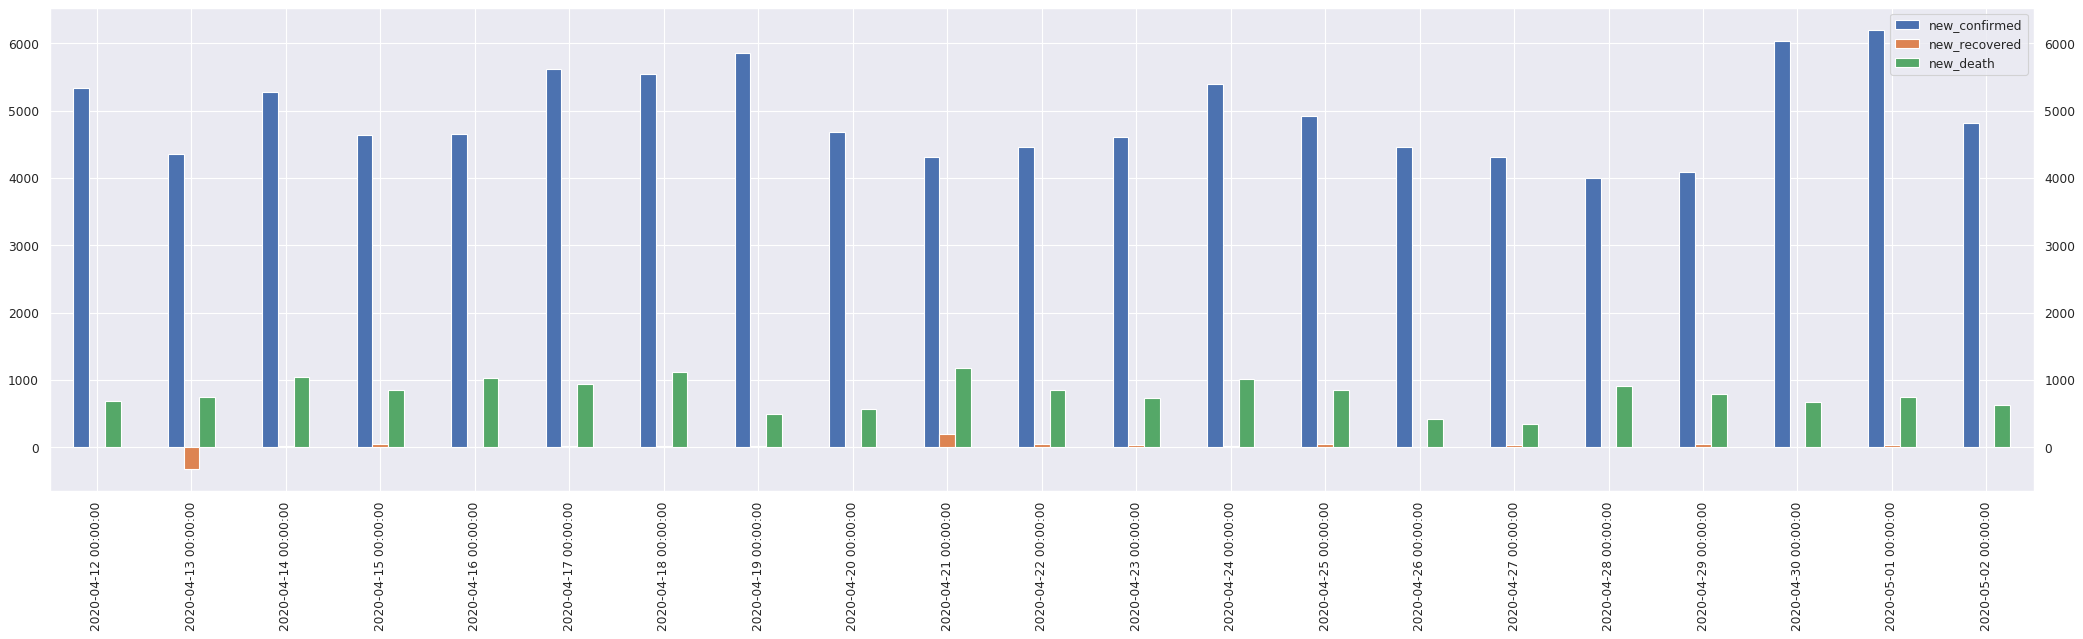

In [54]:
cbr_uk.plot_daily_stats()

In [55]:
cbr_uk.fit(first_date=pd.to_datetime('2020-03-05'))

sigmoid+asymmetric+linear: seor: 703.0853062745398; growth-rate: 0.028, date:2020-06-10 00:00:00, projected value: 4705.625998370043


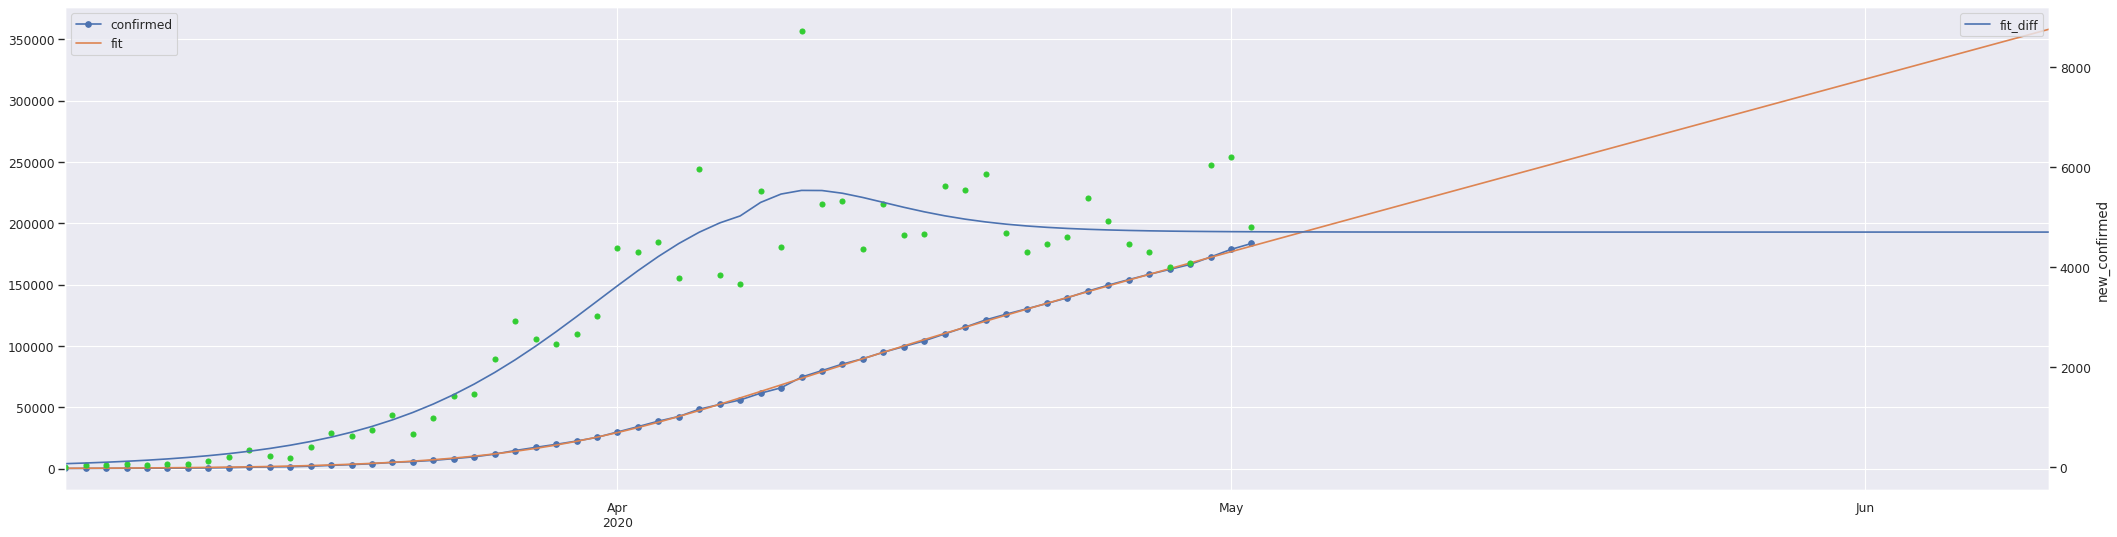

In [56]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_with_fits(ax=ax)

In [57]:
cbr_uk.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5538.648746


In [58]:
cbr_uk.calculate_R_estimates()
cbr_uk.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-30,0.987,1.008,1.17,1.105,1.033


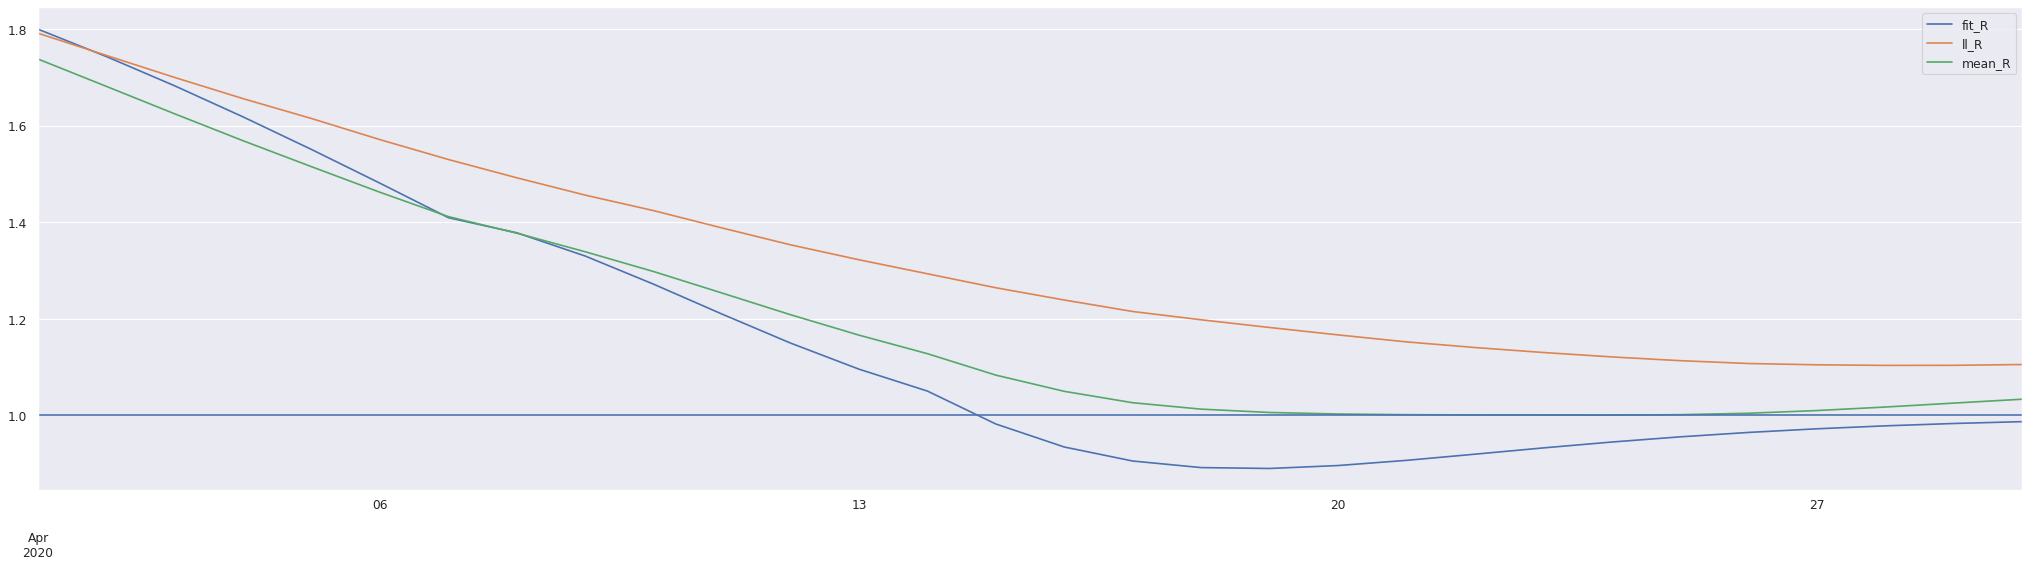

In [59]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [60]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-28,1012582,115936,58355,24385,4512,2096
2020-04-29,1039909,120720,60967,27327,4784,2612
2020-04-30,1069424,153947,62996,29515,33227,2029
2020-05-01,1103461,164015,64943,34037,10068,1947
2020-05-02,1132539,175382,66369,29078,11367,1426


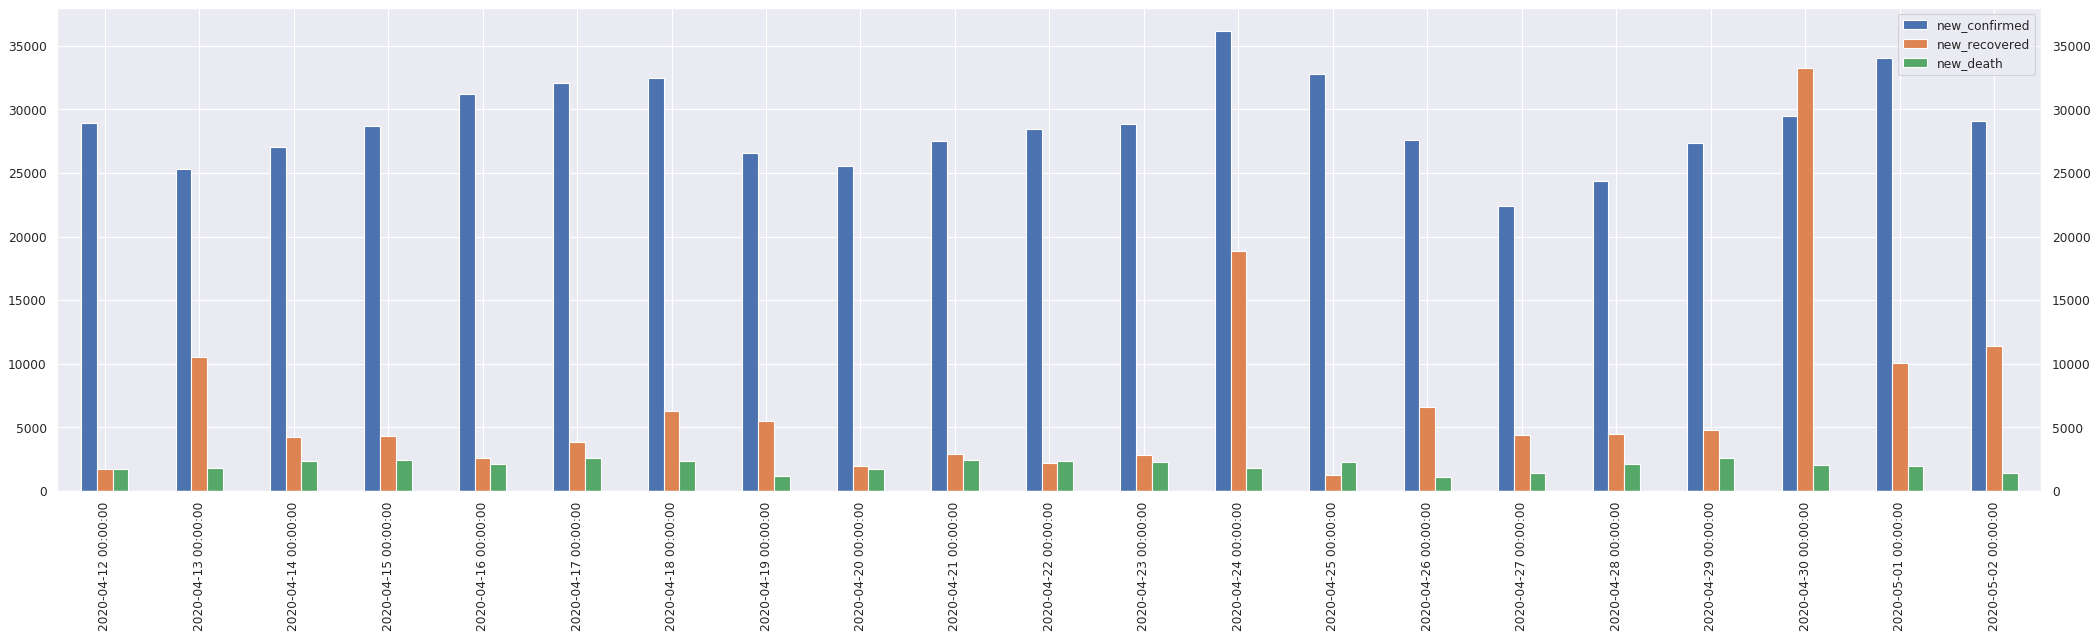

In [61]:
cbr_us.plot_daily_stats()

In [62]:
cbr_us.fit(first_date=pd.to_datetime('2020-03-11'))

sigmoid+linear: seor: 2500.2824813965167, max asymptotic: 214626.79272511744; growth-rate: 0.027, date:2020-06-10 00:00:00, projected value: 28160.575807680565


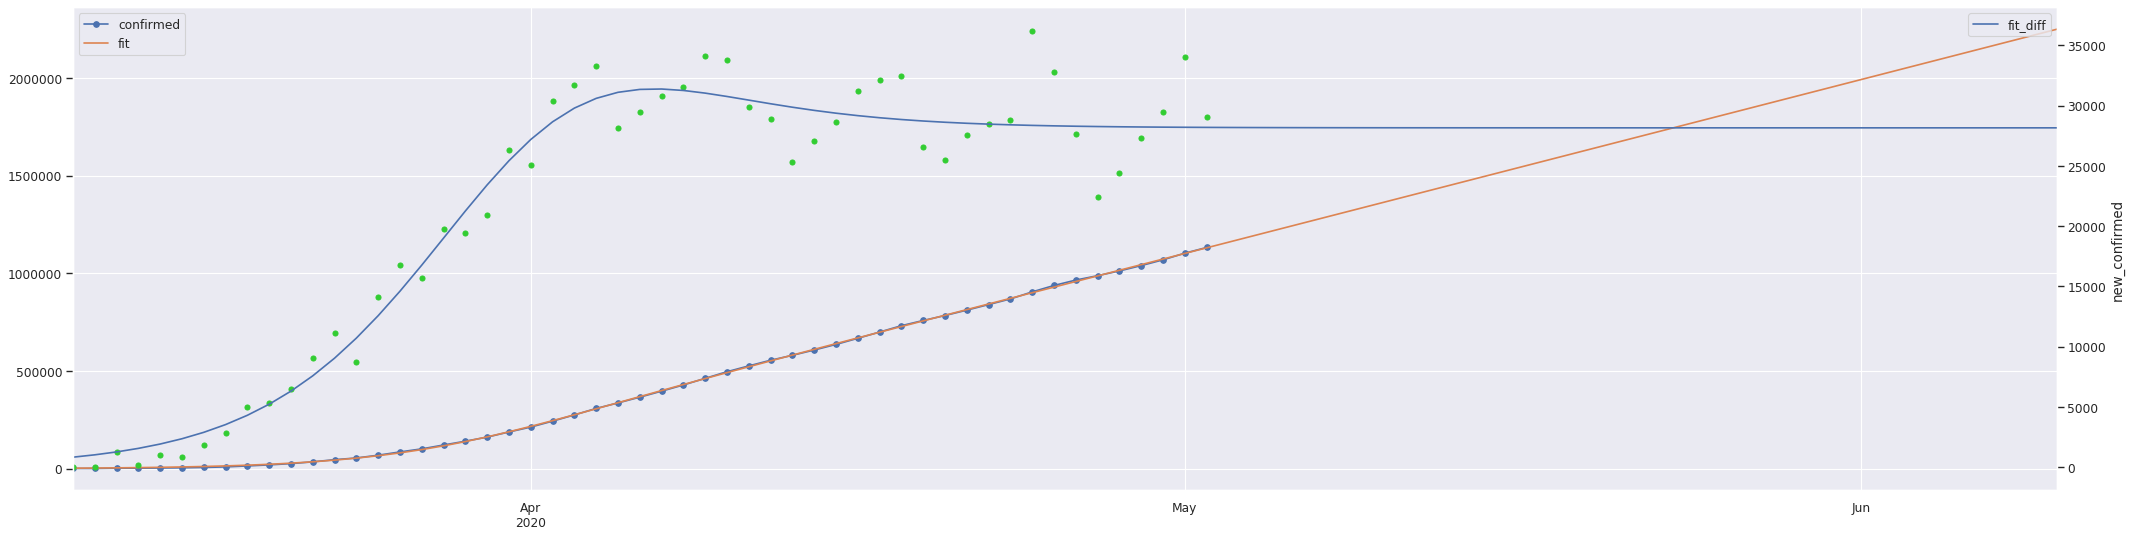

In [63]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_with_fits(ax=ax)

In [64]:
cbr_us.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,31381.30202


In [65]:
cbr_us.calculate_R_estimates()
cbr_us.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-30,0.993,0.881,0.982,1.148,1.008


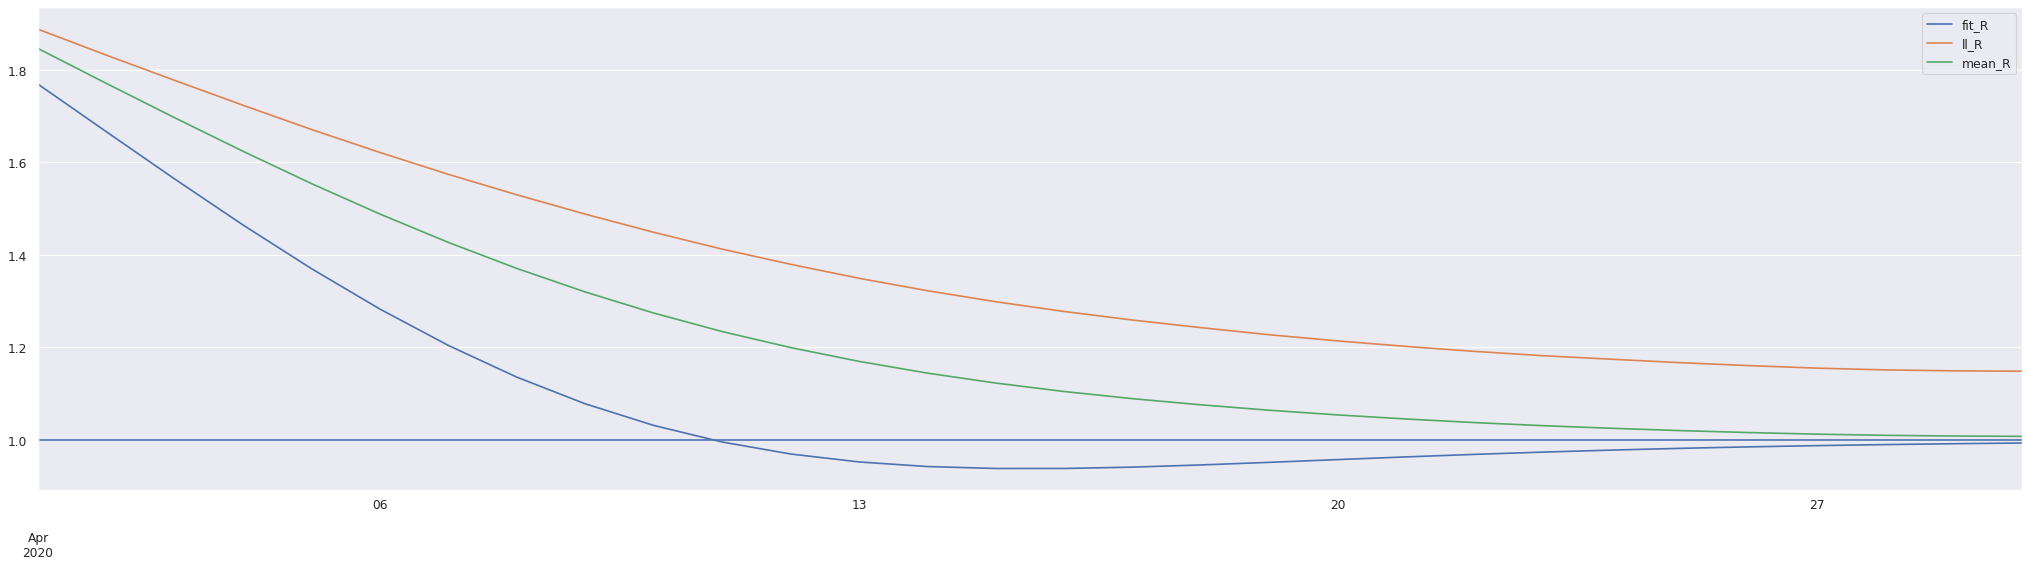

In [66]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [67]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-28,29264,22600,1699,100,400,34
2020-04-29,29407,22600,1716,143,0,17
2020-04-30,29586,23400,1737,179,800,21
2020-05-01,29705,23900,1754,119,500,17
2020-05-02,29817,24200,1762,112,300,8


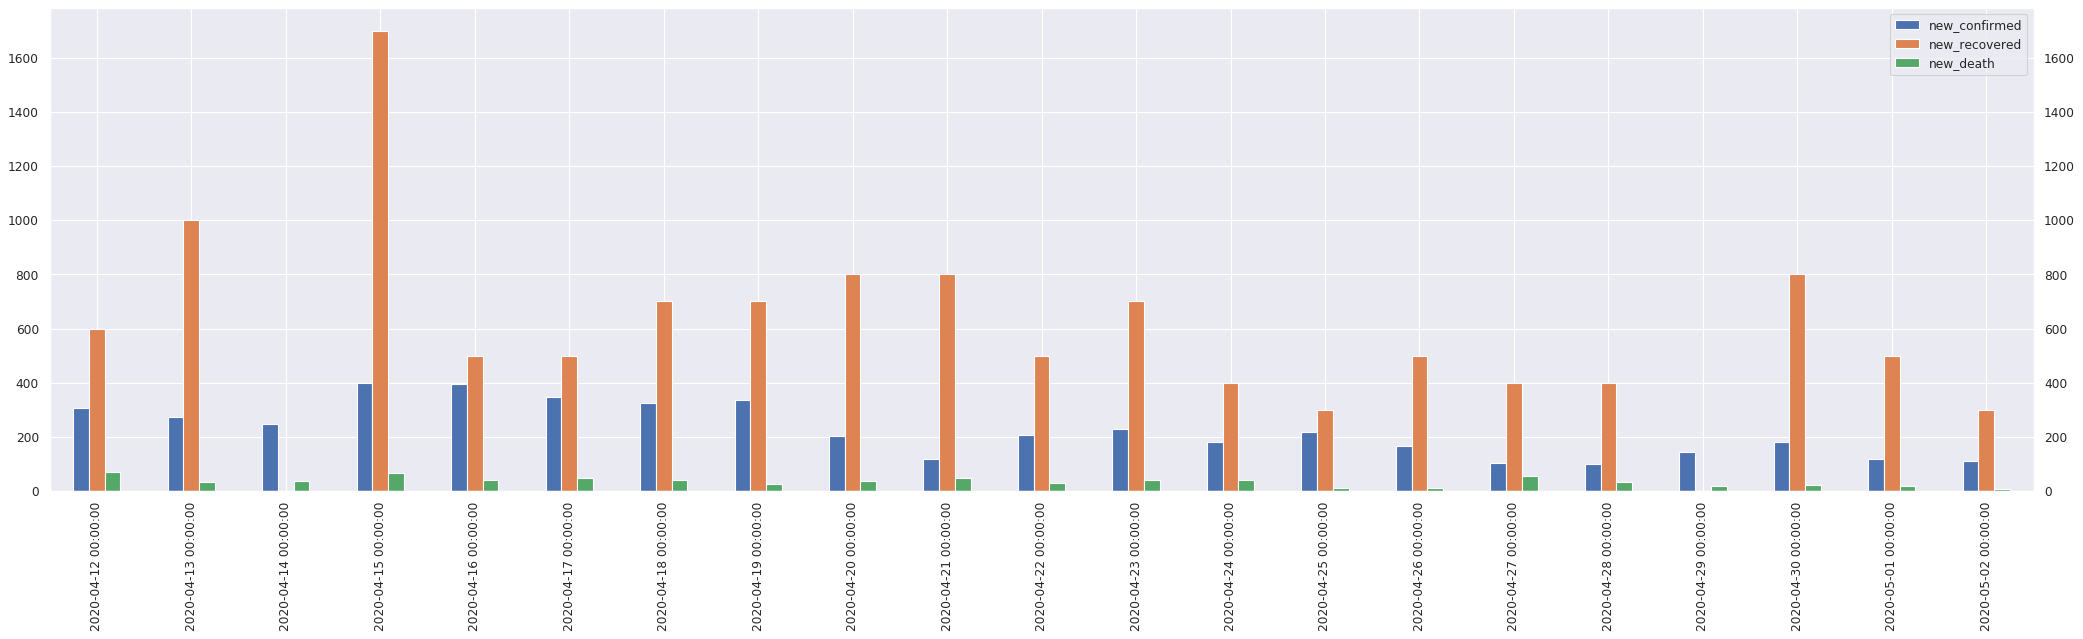

In [68]:
cbr_switzerland.plot_daily_stats()

In [69]:
cbr_switzerland.fit(first_date=pd.to_datetime('2020-03-05'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 171.71811975141023, max asymptotic: 30450.297445374636; growth-rate: 0.003, date:2020-05-02 00:00:00, projected value: 90.8257001031602


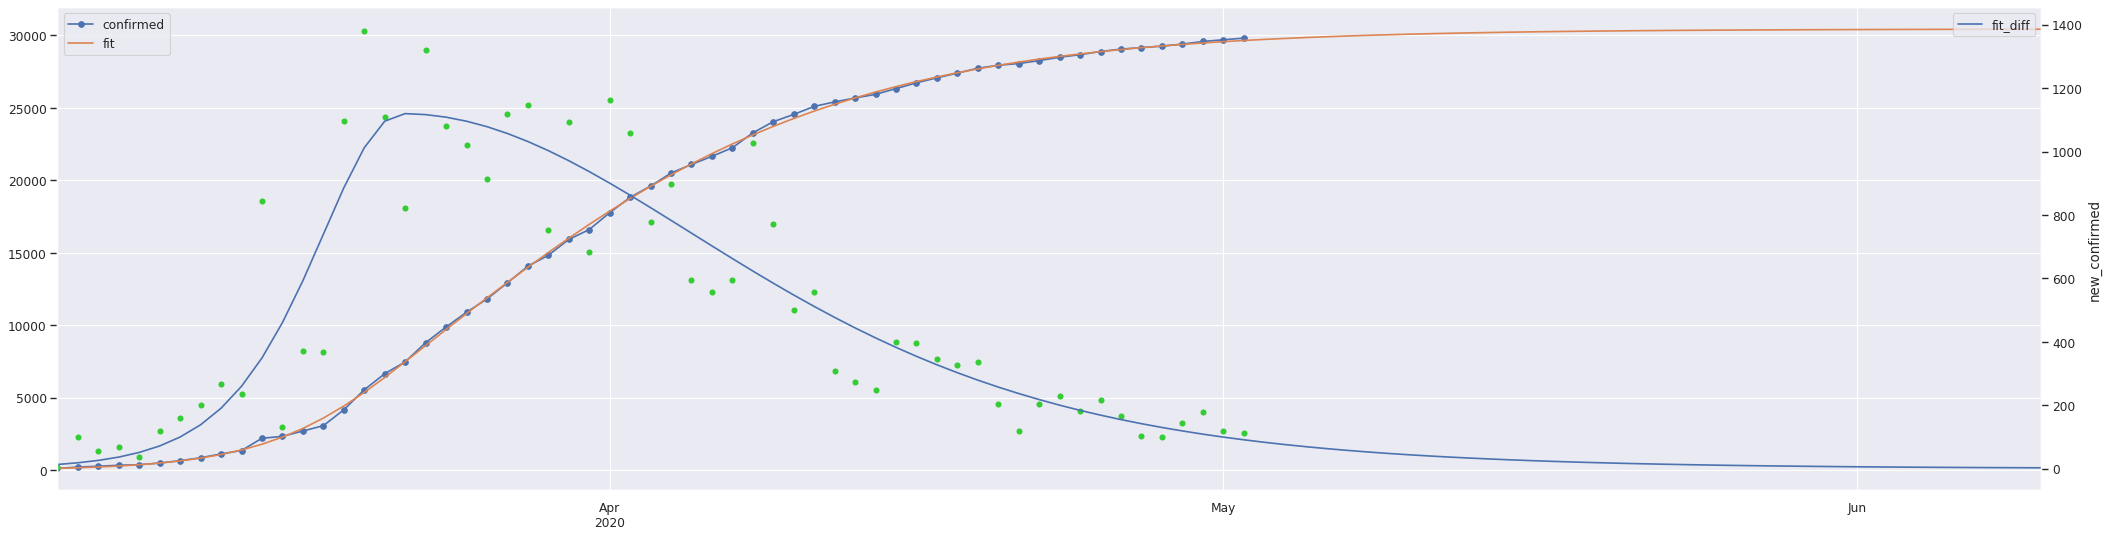

In [70]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_with_fits(ax=ax)

In [71]:
cbr_switzerland.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,1119.510384


In [72]:
cbr_switzerland.calculate_R_estimates()
cbr_switzerland.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-30,0.417,0.581,0.713,0.568,0.522


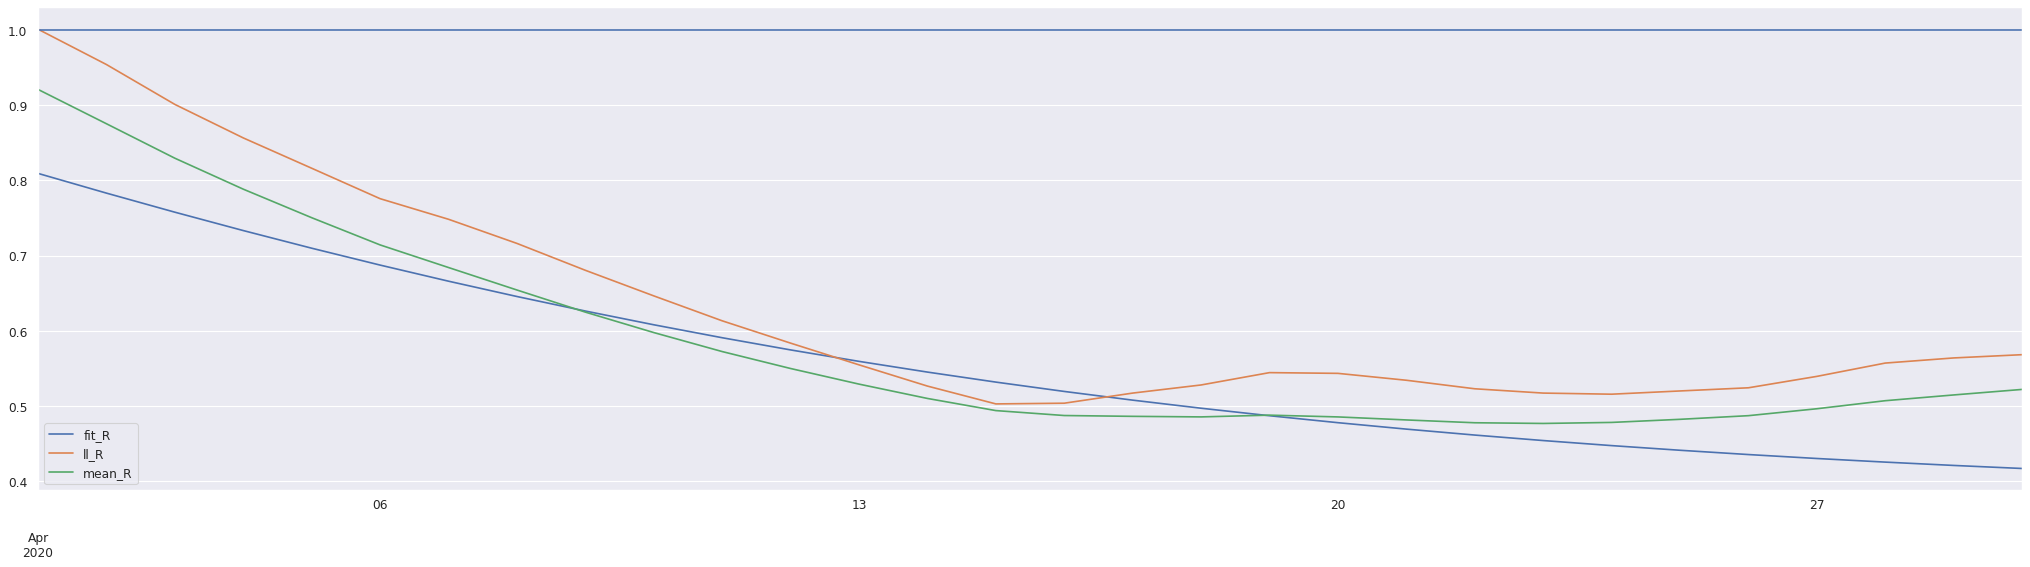

In [73]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [74]:
cbr_australia = covid19.CasesByRegion('Australia')
cbr_australia.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-28,6744,5665,89,23,77,6
2020-04-29,6752,5715,91,8,50,2
2020-04-30,6766,5742,93,14,27,2
2020-05-01,6778,5775,93,12,33,0
2020-05-02,6799,5814,94,21,39,1


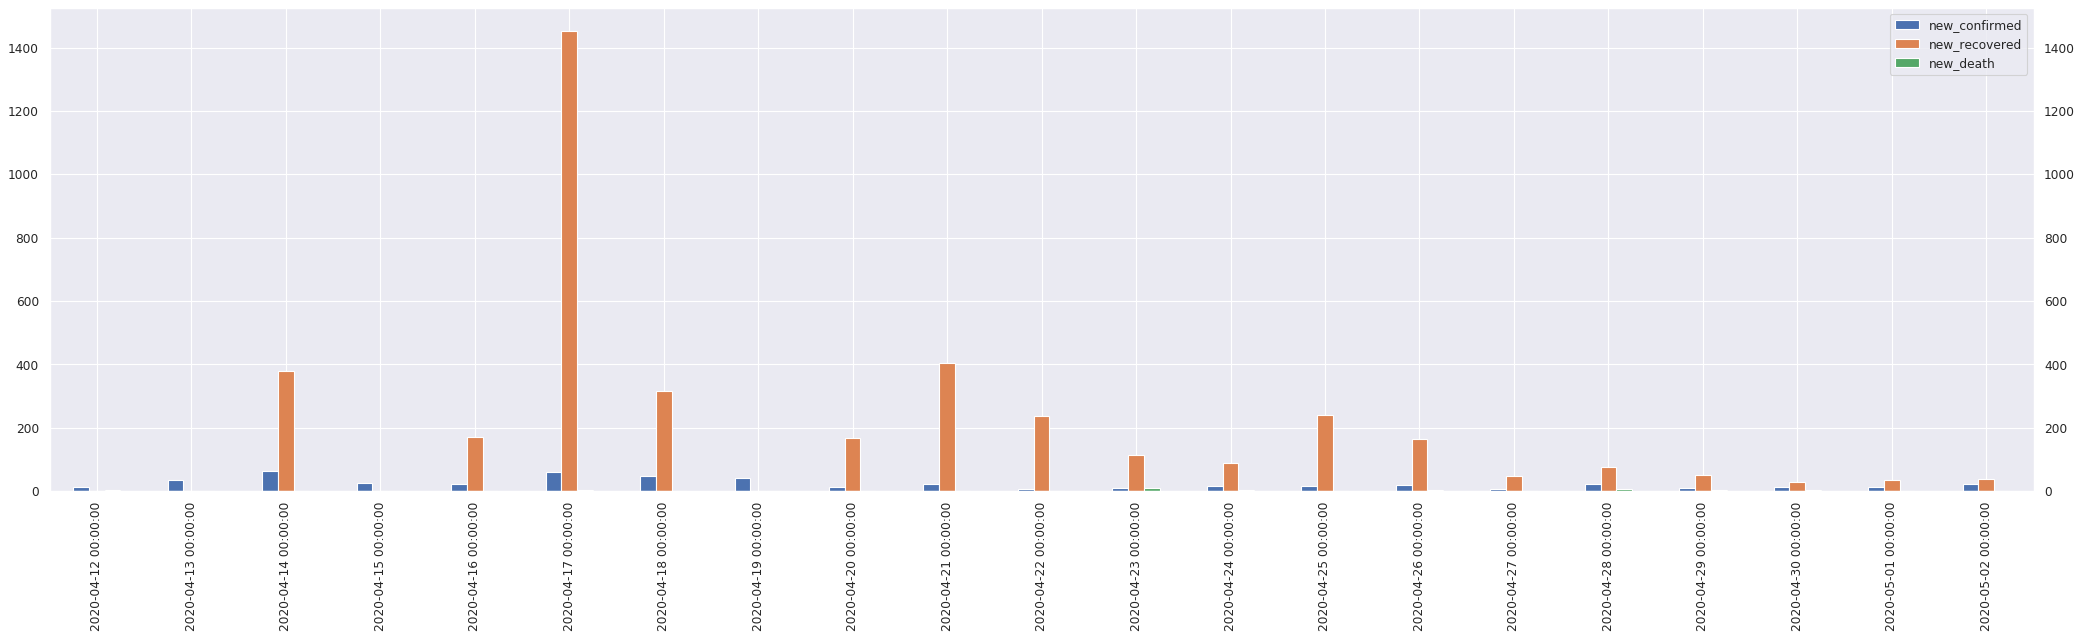

In [75]:
cbr_australia.plot_daily_stats()

In [76]:
cbr_australia.fit(first_date=pd.to_datetime('2020-03-10'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+linear: seor: 53.696071096888275, max asymptotic: 6015.718939314925; growth-rate: 0.004, date:2020-04-09 00:00:00, projected value: 74.79893250834098


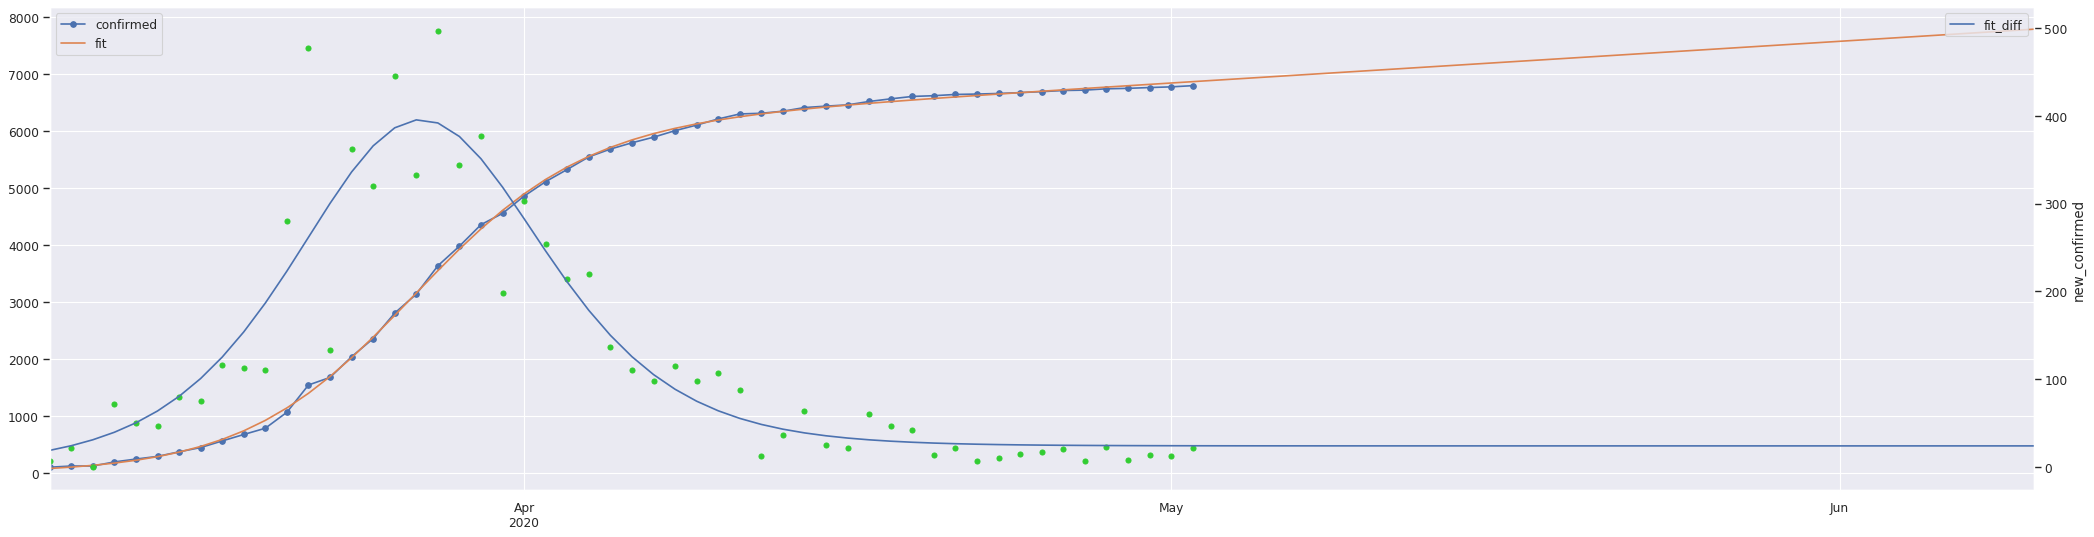

In [77]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_with_fits(ax=ax)

In [78]:
cbr_australia.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,395.542618


In [79]:
cbr_australia.calculate_R_estimates()
cbr_australia.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-30,0.949,0.722,1.298,0.707,0.793


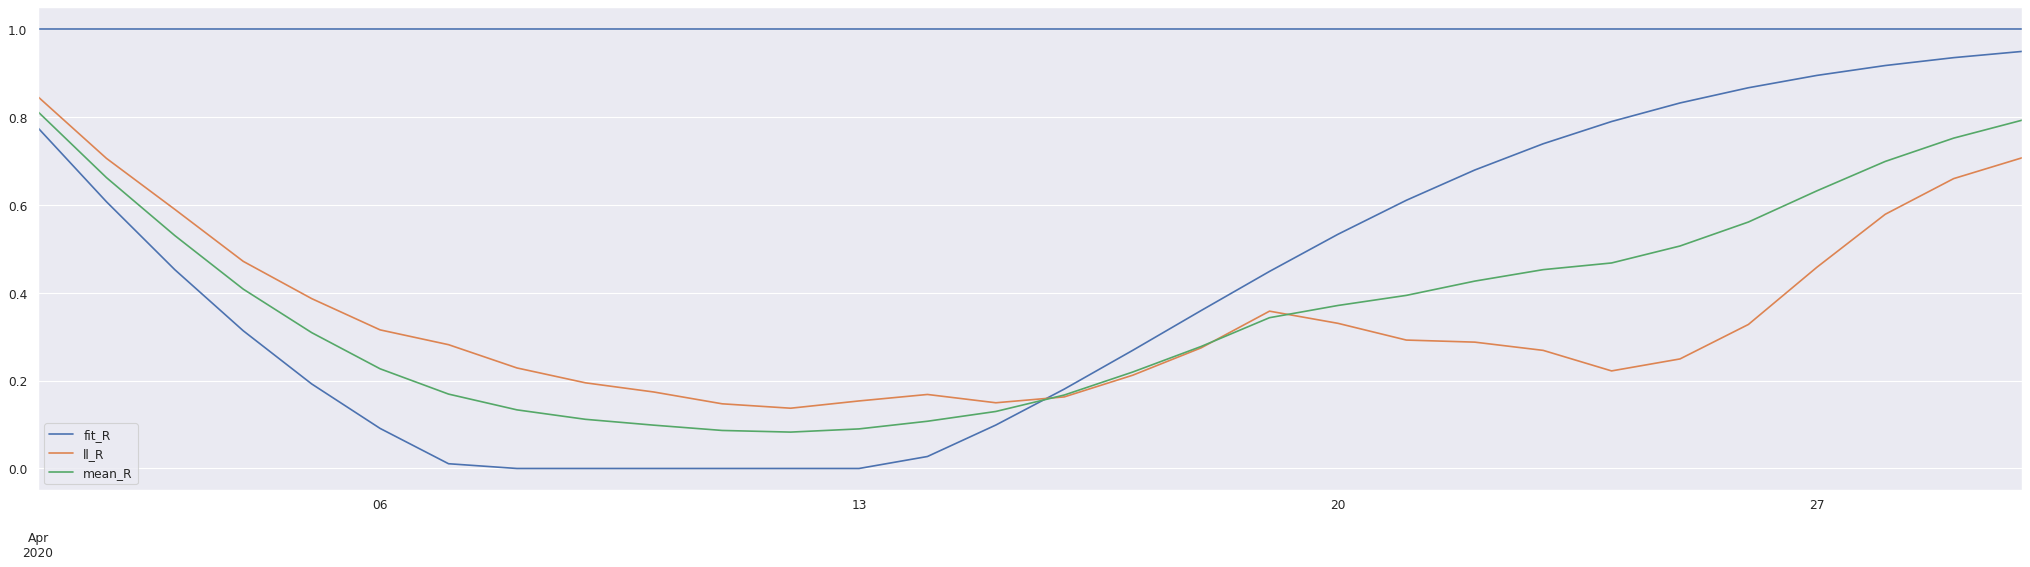

In [80]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [81]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-05-02,,,,,
MS Zaandam,9,0,2,22.222222,66.666667
Nicaragua,14,7,3,21.428571,27.272727
Yemen,10,1,2,20.000000,50.000000
Belgium,49517,12211,7765,15.681483,38.869700
United Kingdom,183500,896,28205,15.370572,96.917738


In [82]:
df_co[df_co.confirmed > 6500].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-05-02,,,,,
Belgium,49517,12211,7765,15.7,38.9
United Kingdom,183500,896,28205,15.4,96.9
France,168518,50663,24763,14.7,32.8
Italy,209328,79914,28710,13.7,26.4
Netherlands,40434,138,5003,12.4,97.3
Sweden,22082,1005,2669,12.1,72.6
Spain,216582,117248,25100,11.6,17.6
Mexico,22088,12377,2061,9.3,14.3
Indonesia,10843,1665,831,7.7,33.3
